# This notebook is not meant to be implemented by others. All the data shown here are from one of my current projects, and are unpublished. This is only to show potential employers as a portfolio.

Author: IMRUL FAISAL

This workflow contains basic analysis and visualization of two groups of 10000 immune cells sequenced by Chromium 10X method. The starting point is reading mtx matrix from 10X directory. Neither I would publish cell type identification etc. steps here. It will only show standard single cell analysis pipeline and some common visualizations.

In [152]:
#!pip install tf-nightly
#!pip install tfp-nightly
#!pip install tensorflow
#!pip install tensorflow-probability
#!pip install diffxpy
#!pip install scanpy
#!pip install leidenalg

In [153]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import rcParams
#import diffxpy.api as de

In [154]:
# These commands to be run on terminal
# !mkdir data
# !cd data
# !mkdir write

In [155]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.6


In [156]:
results_file_ki = '/data/write/adata_ki.h5ad'  # the file that will store the analysis results
results_file_wt = '/data/write/adata_wt.h5ad'

In [157]:
# Reading directory for the first group
adata_ki = sc.read_10x_mtx(
    'filtered_feature_bc_matrix_KI/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata_ki.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... reading from cache file cache/filtered_feature_bc_matrix_KI-matrix.h5ad


In [158]:
# Reading directory for the second group
adata_wt = sc.read_10x_mtx(
    'filtered_feature_bc_matrix_WT/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata_wt.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... reading from cache file cache/filtered_feature_bc_matrix_WT-matrix.h5ad


In [159]:
adata_ki # AnnData object for the first group
adata_wt # AnnData object for the second group

AnnData object with n_obs × n_vars = 8636 × 32285
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


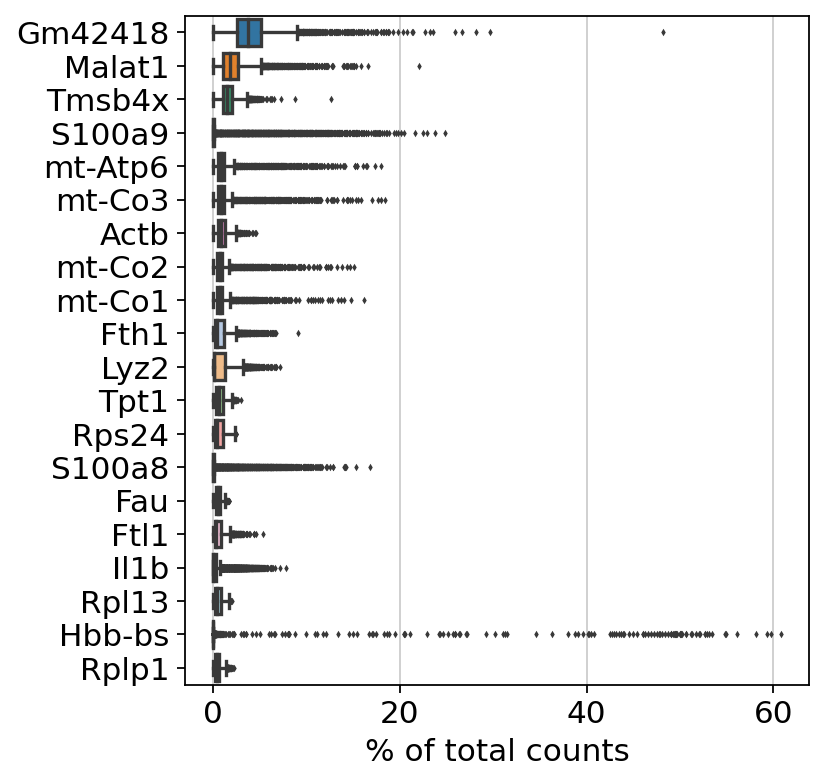

normalizing counts per cell
    finished (0:00:00)


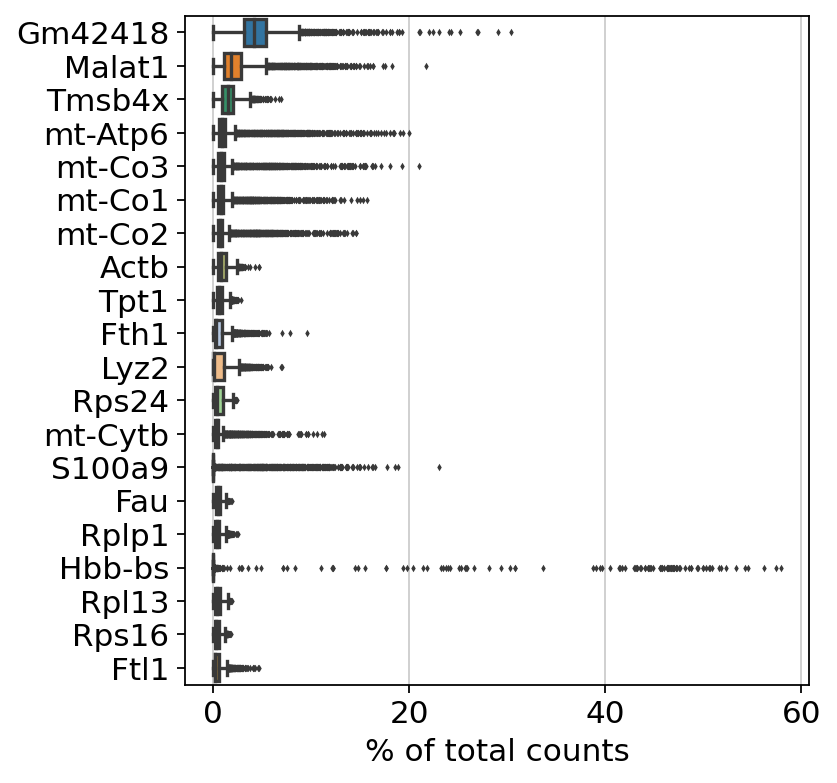

In [160]:
sc.pl.highest_expr_genes(adata_ki, n_top=20, ) # top 20 highest expressed genes from the first group
sc.pl.highest_expr_genes(adata_wt, n_top=20, ) # top 20 highest expressed genes from the second group

In [161]:
# some basic preprocessing steps
sc.pp.filter_cells(adata_ki, min_genes=200)
sc.pp.filter_genes(adata_ki, min_cells=3)
sc.pp.filter_cells(adata_wt, min_genes=200)
sc.pp.filter_genes(adata_wt, min_cells=3)

filtered out 72 cells that have less than 200 genes expressed
filtered out 15179 genes that are detected in less than 3 cells
filtered out 99 cells that have less than 200 genes expressed
filtered out 14973 genes that are detected in less than 3 cells


In [162]:
adata_ki

AnnData object with n_obs × n_vars = 8990 × 17106
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [163]:
adata_ki.var

gene_ids    feature_types  n_cells
Sox17           ENSMUSG00000025902  Gene Expression        3
Mrpl15          ENSMUSG00000033845  Gene Expression     1576
Lypla1          ENSMUSG00000025903  Gene Expression     1550
Tcea1           ENSMUSG00000033813  Gene Expression     2768
Atp6v1h         ENSMUSG00000033793  Gene Expression     2120
...                            ...              ...      ...
Csprs           ENSMUSG00000062783  Gene Expression      155
Vamp7           ENSMUSG00000051412  Gene Expression      977
Tmlhe           ENSMUSG00000079834  Gene Expression       82
CAAA01147332.1  ENSMUSG00000095742  Gene Expression       63
AC149090.1      ENSMUSG00000095041  Gene Expression     2063

[17106 rows x 3 columns]

In [164]:
# checking if there are readouts from mitochondrial genes
sum(adata_ki.var_names.str.startswith('mt-'))

13

In [165]:
adata_ki.var['mt'] = adata_ki.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_ki, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_wt.var['mt'] = adata_wt.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_wt, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical


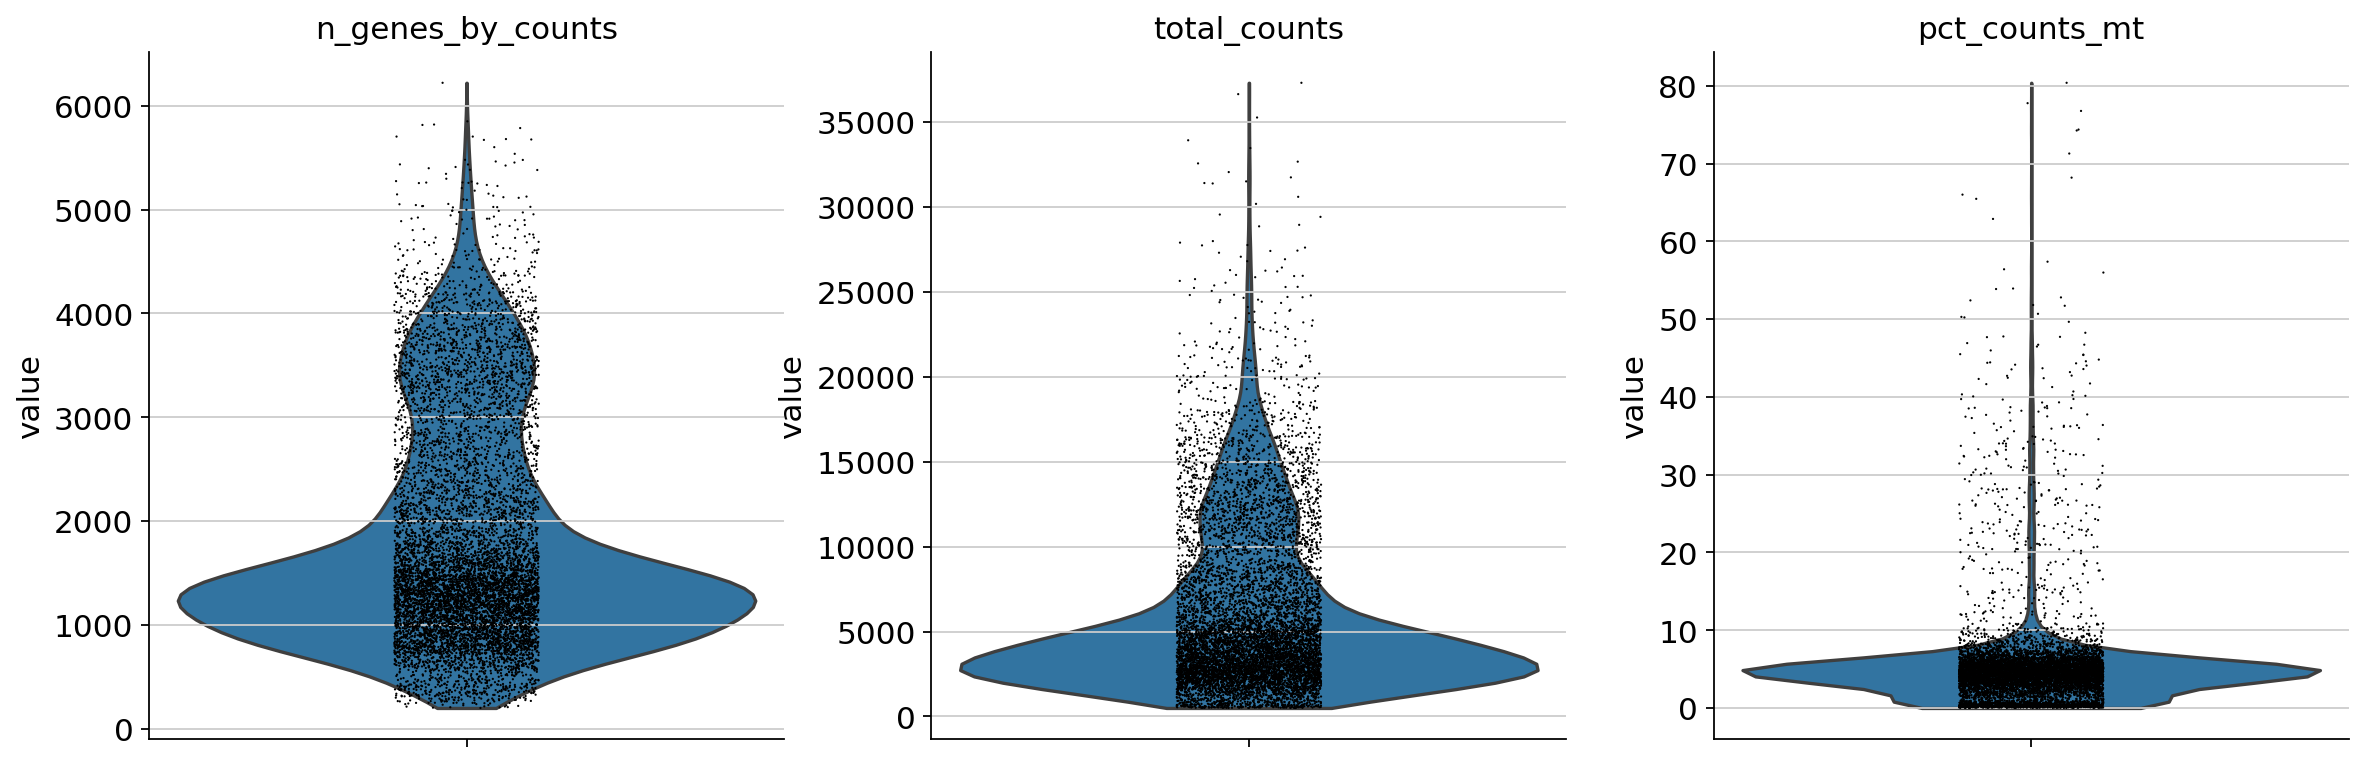

... storing 'feature_types' as categorical


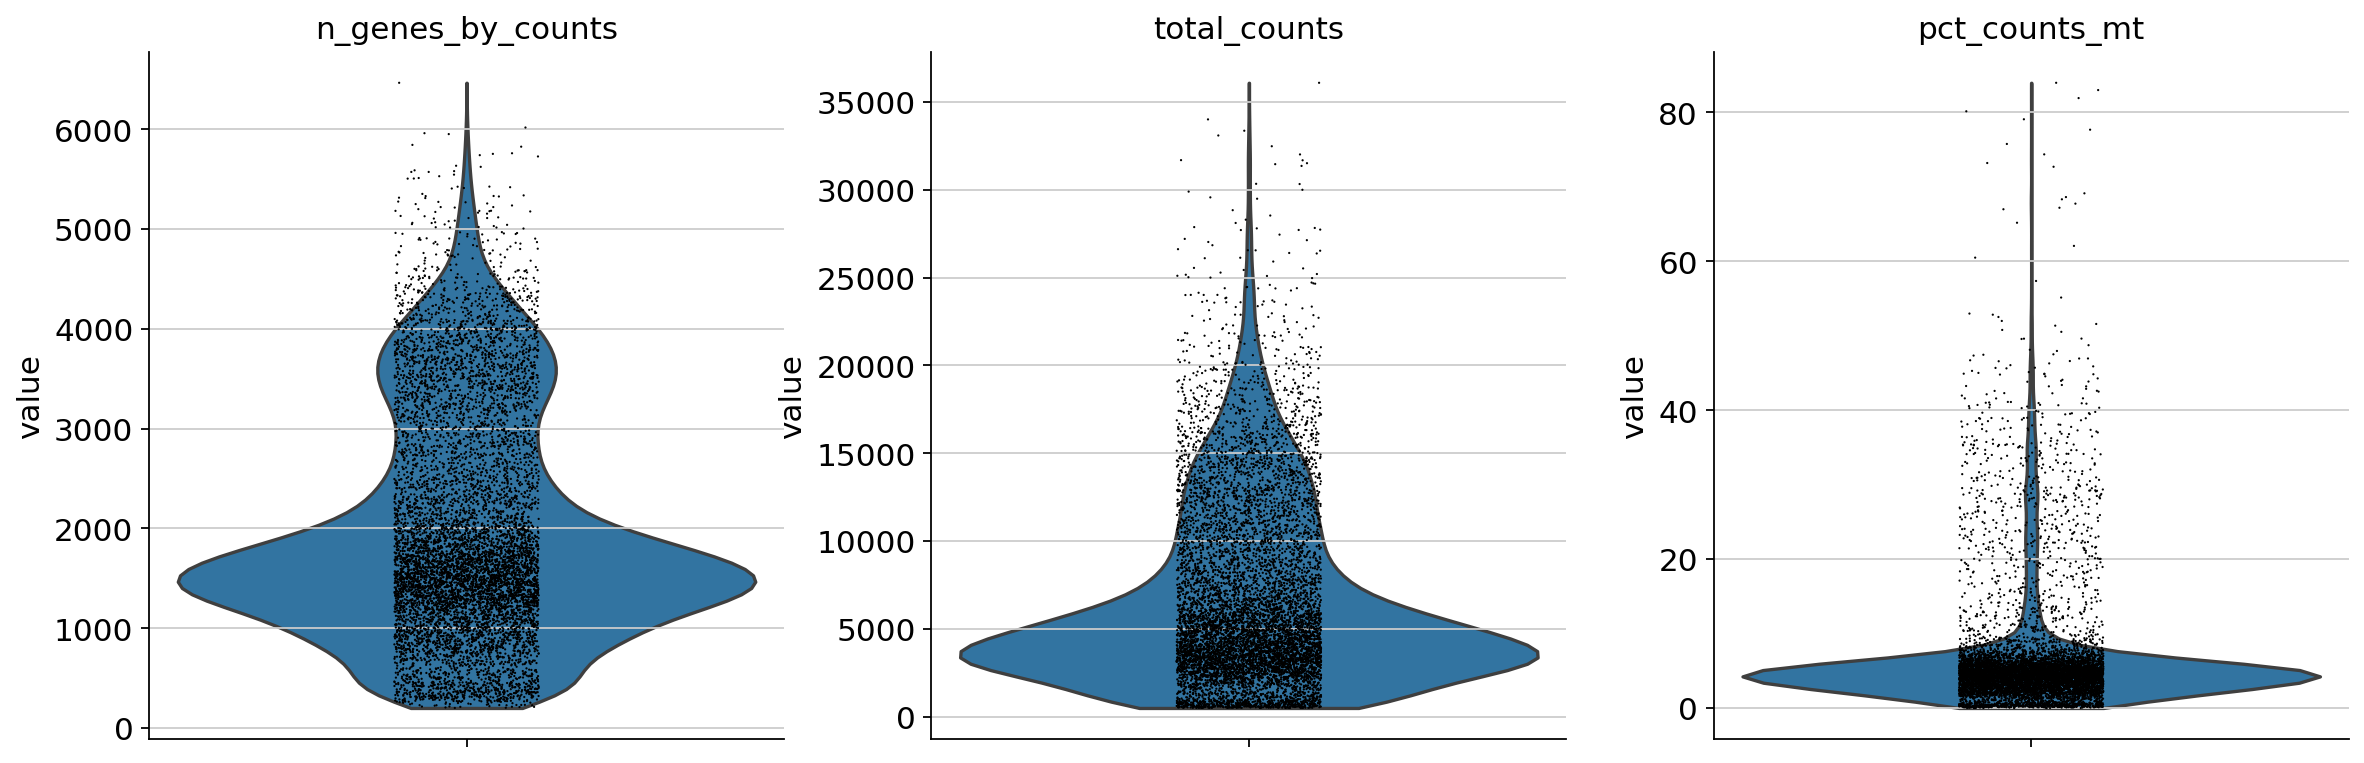

In [166]:
# Basic QC overviews violin plots
sc.pl.violin(adata_ki, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.1, multi_panel=True)
sc.pl.violin(adata_wt, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.1, multi_panel=True)

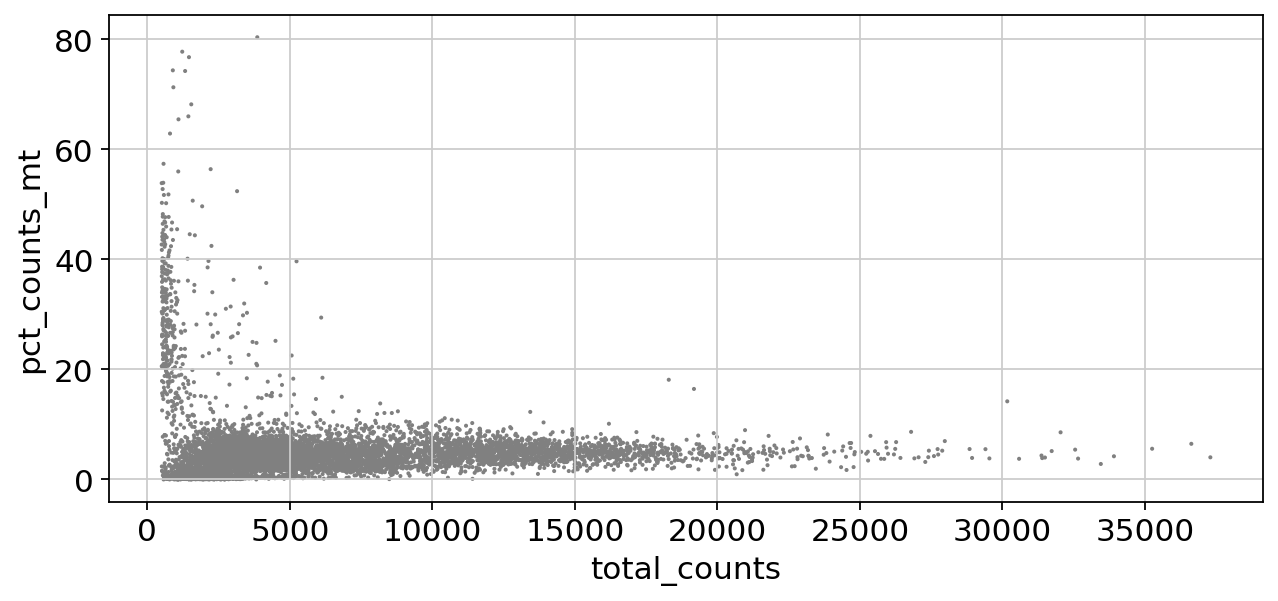

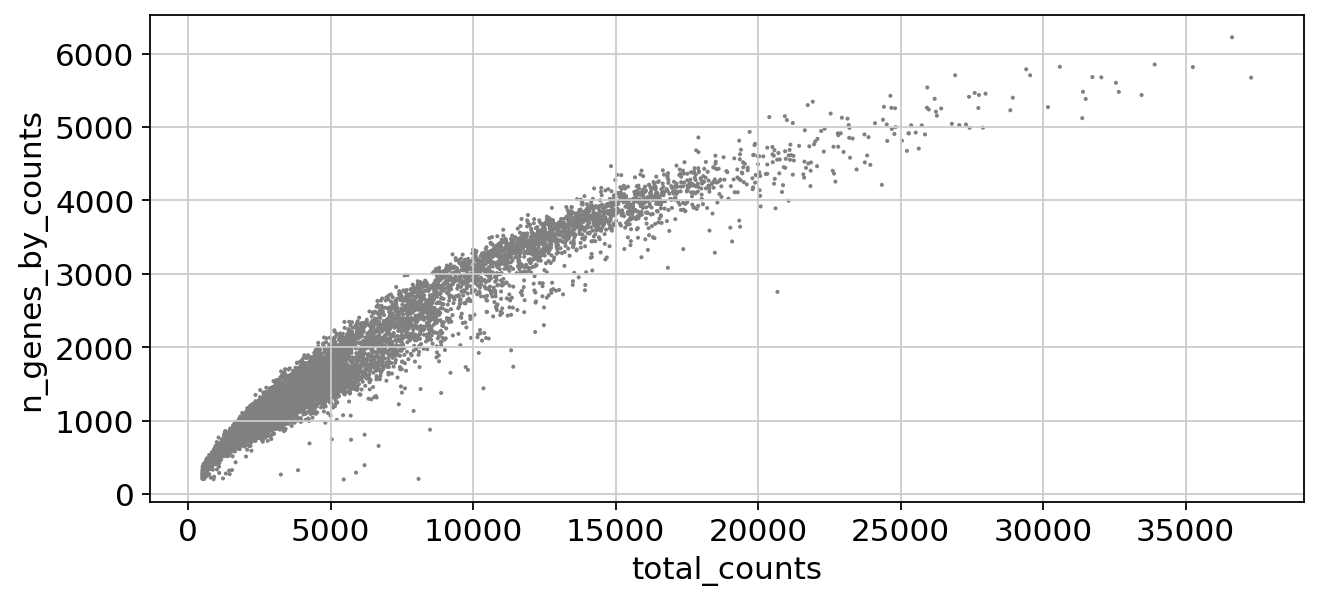

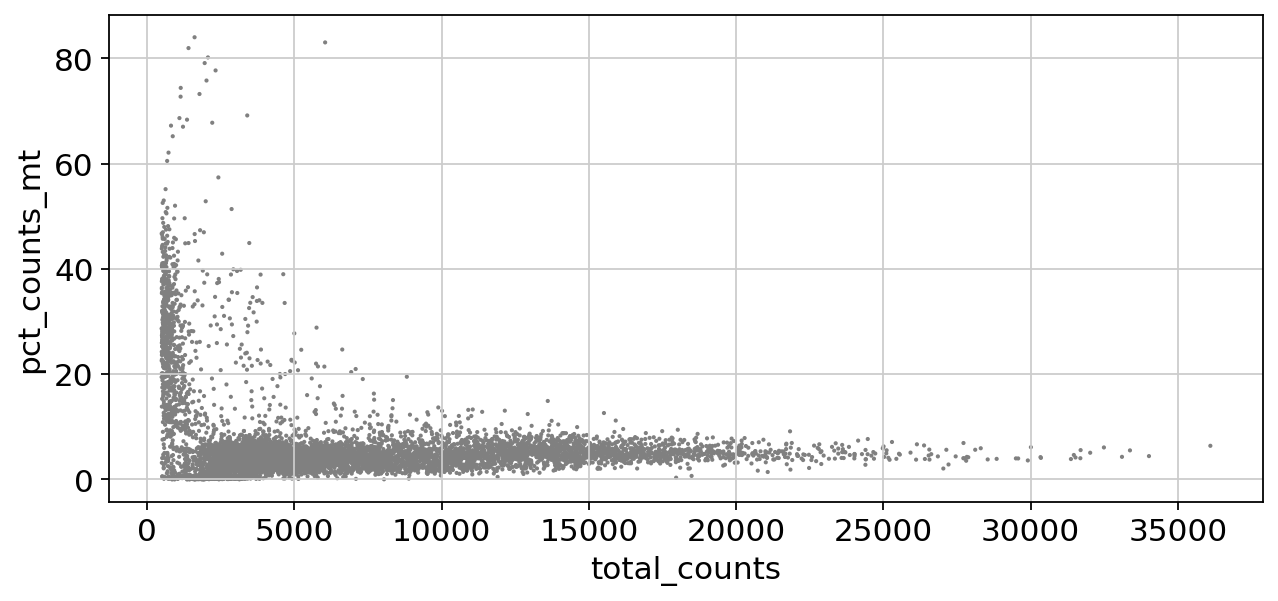

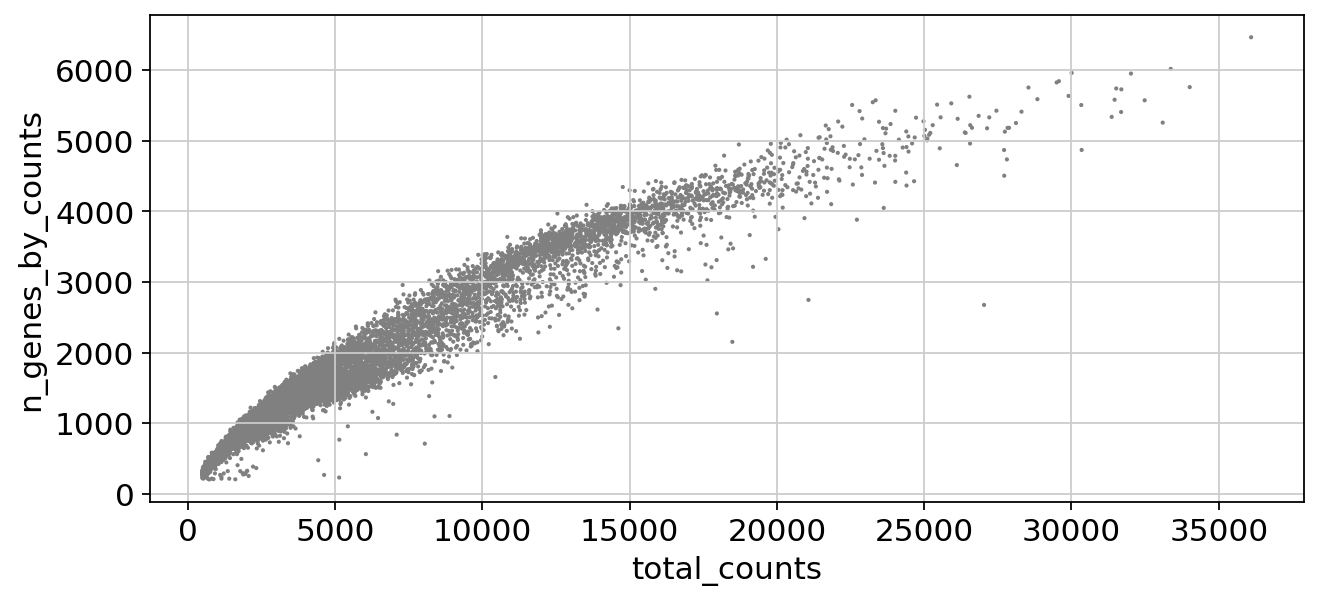

In [167]:
rcParams['figure.figsize'] = 8, 4
sc.pl.scatter(adata_ki, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_ki, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata_wt, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_wt, x='total_counts', y='n_genes_by_counts')

In [168]:
# Filtering out cells that have too many mitochondrial genes expressed or too many total counts
adata_ki = adata_ki[adata_ki.obs.n_genes_by_counts < 2500, :]
adata_ki = adata_ki[adata_ki.obs.pct_counts_mt < 5, :]
adata_wt = adata_wt[adata_wt.obs.n_genes_by_counts < 2500, :]
adata_wt = adata_wt[adata_wt.obs.pct_counts_mt < 5, :]

In [169]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata_ki, target_sum=1e4)
sc.pp.normalize_total(adata_wt, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [170]:
sc.pp.log1p(adata_ki)
sc.pp.log1p(adata_wt)

In [171]:
sc.pp.highly_variable_genes(adata_ki)
sc.pp.highly_variable_genes(adata_wt)
#, min_mean=0.0125, max_mean=3, min_disp=0.5

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


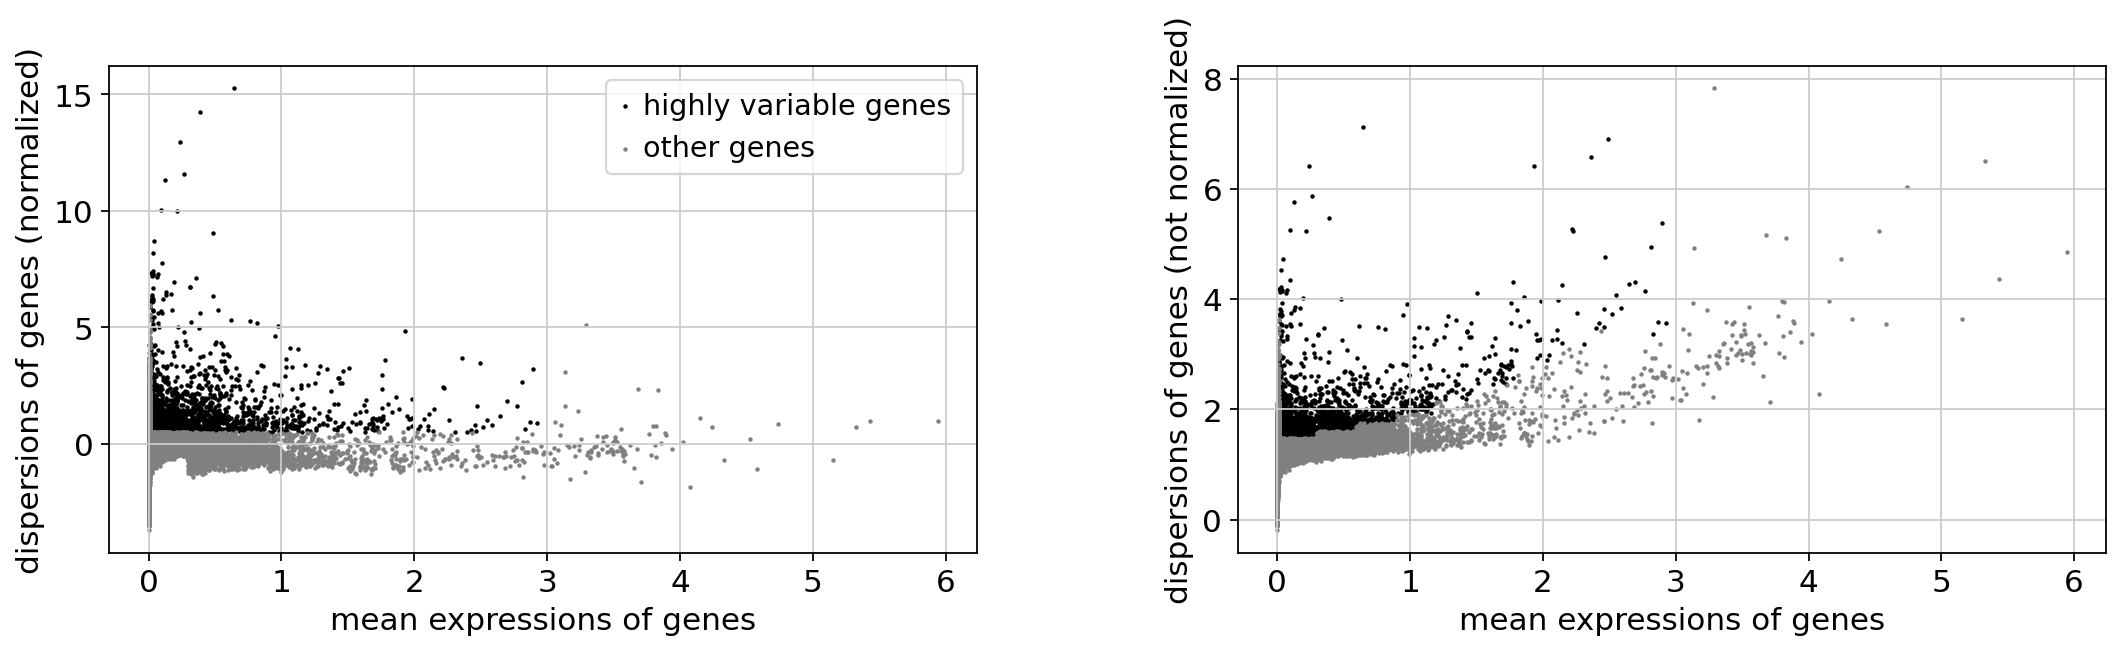

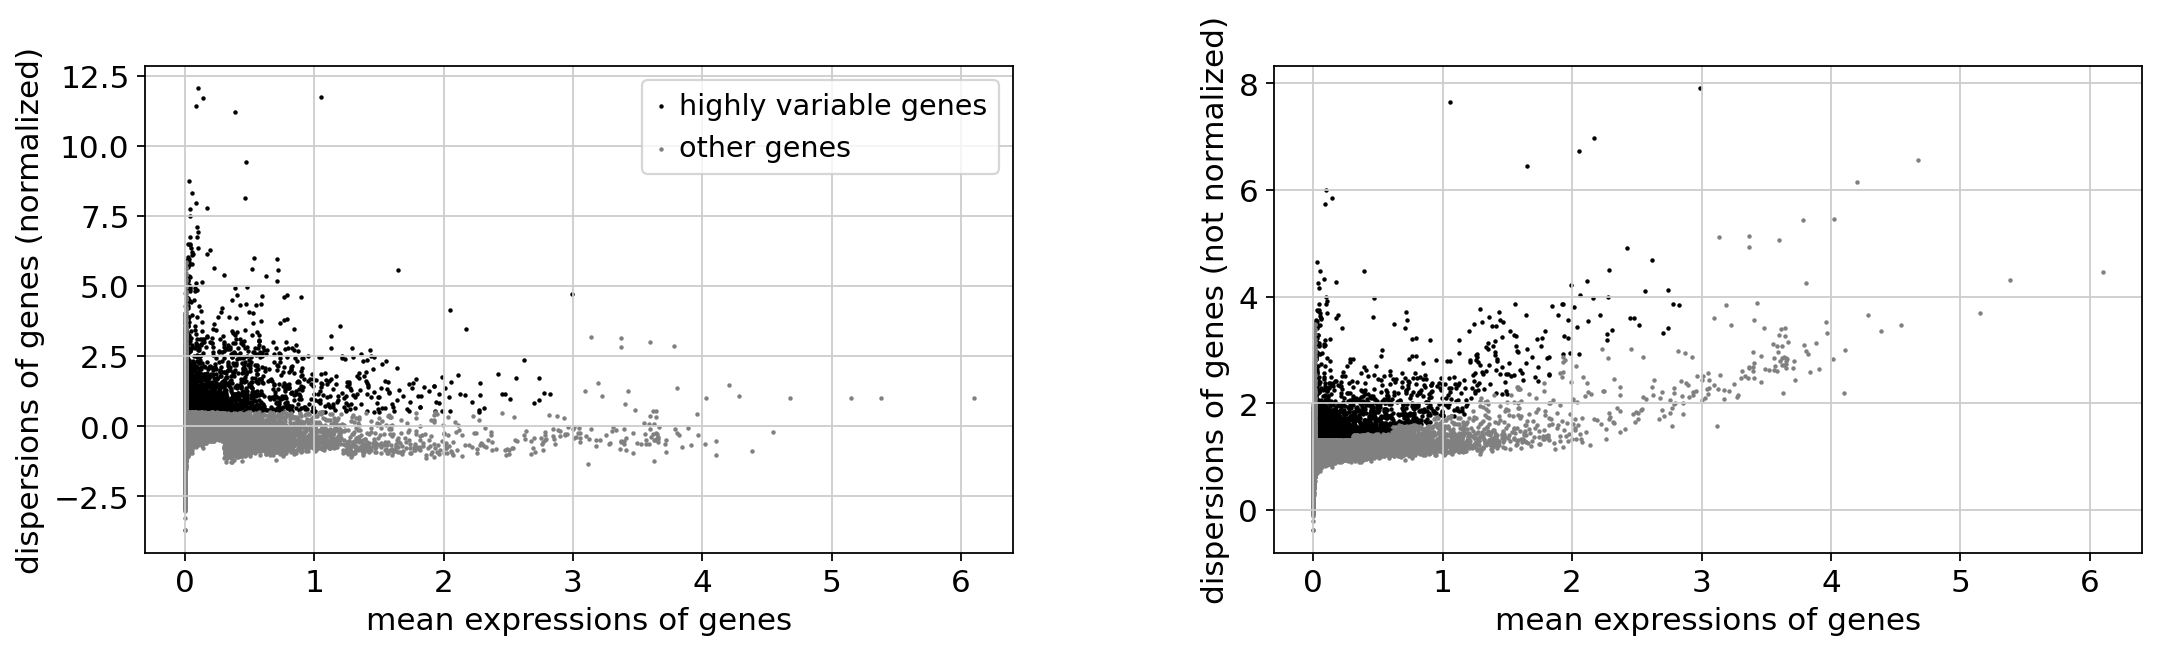

In [172]:
rcParams['figure.figsize'] = 8, 4
sc.pl.highly_variable_genes(adata_ki)
sc.pl.highly_variable_genes(adata_wt)

In [173]:
adata_ki.raw = adata_ki
adata_wt.raw = adata_wt

In [174]:
#adata_ki.var.highly_variable

In [175]:
adata_ki = adata_ki[:, adata_ki.var.highly_variable]
adata_wt = adata_wt[:, adata_wt.var.highly_variable]

In [176]:
len(adata_ki.var.highly_variable)

2385

In [177]:
len(adata_wt.var.highly_variable)

2195

In [178]:
sc.pp.regress_out(adata_ki, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata_wt, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:16)


In [179]:
sc.pp.scale(adata_ki, max_value=10)
sc.pp.scale(adata_wt, max_value=10)

In [180]:
sc.tl.pca(adata_ki, svd_solver='arpack')
sc.tl.pca(adata_wt, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


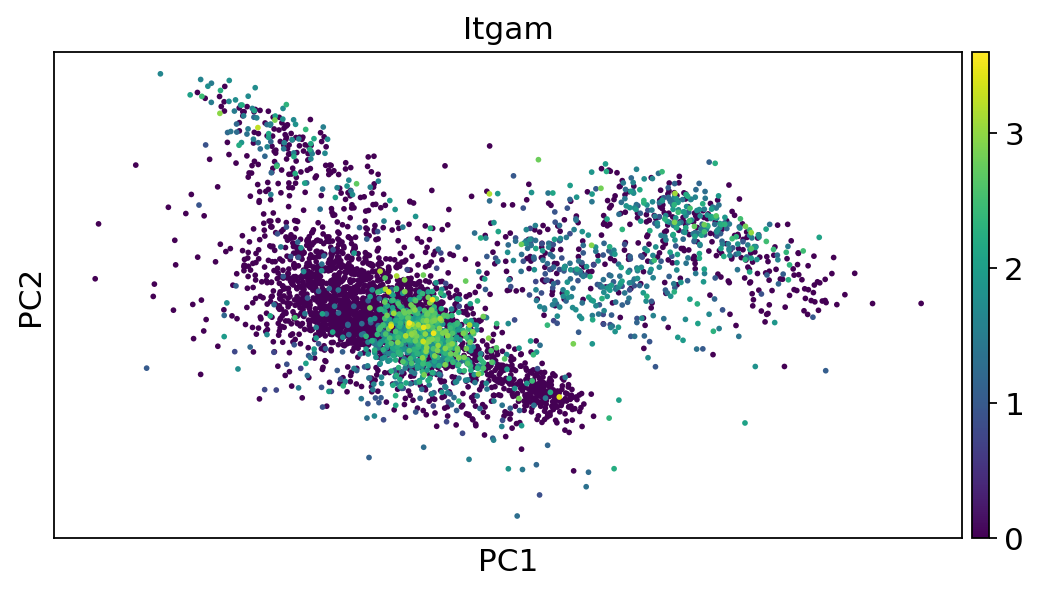

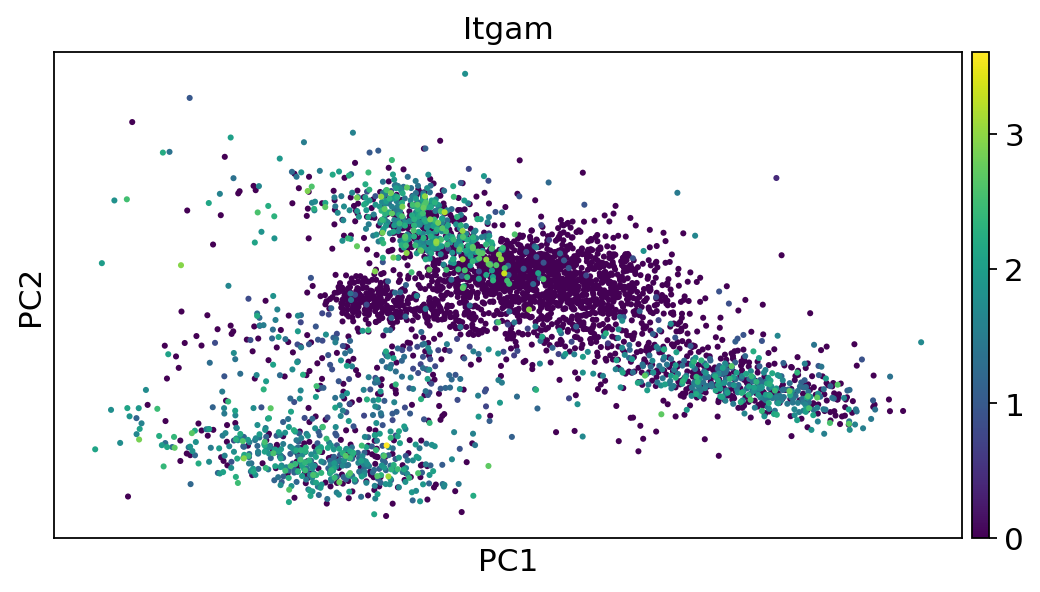

In [181]:
rcParams['figure.figsize'] = 8, 4
sc.pl.pca(adata_ki, color='Itgam')
sc.pl.pca(adata_wt, color='Itgam')

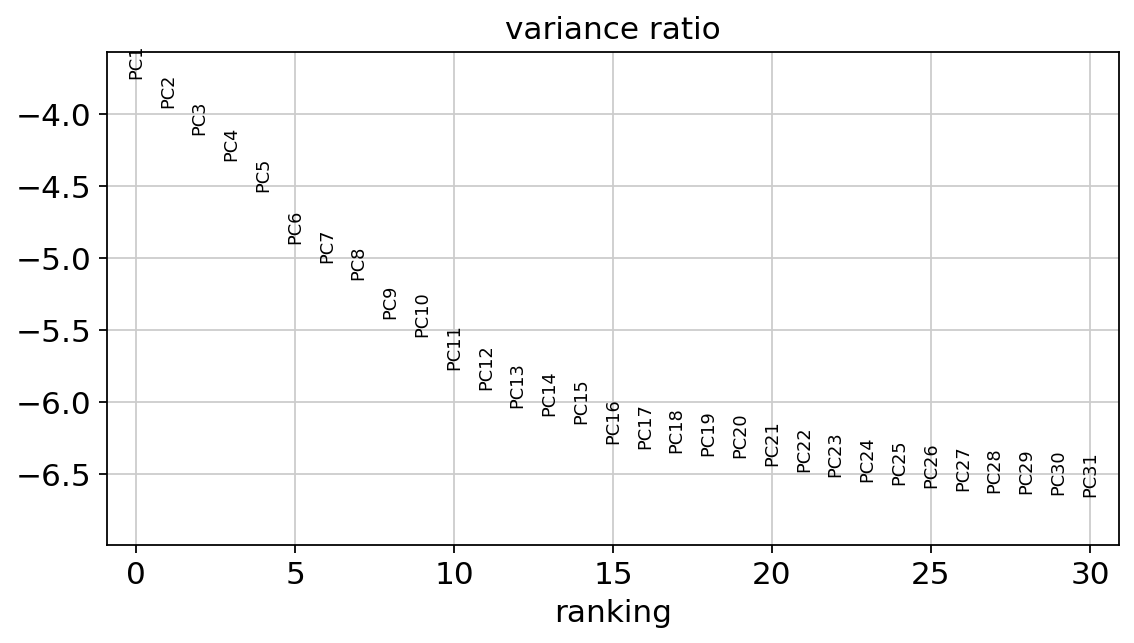

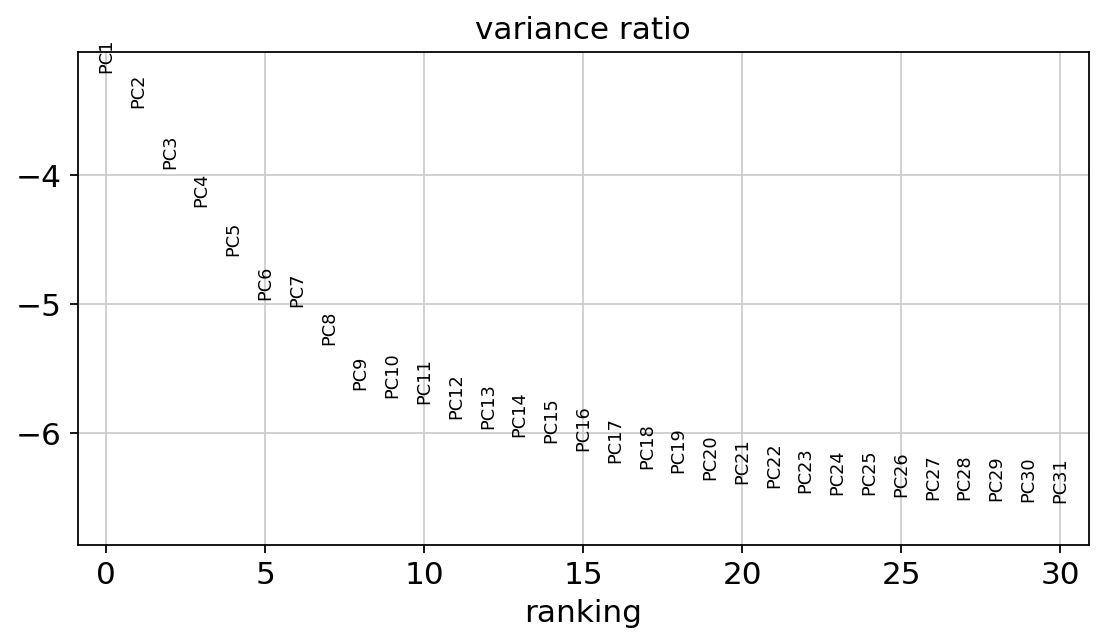

In [182]:
sc.pl.pca_variance_ratio(adata_ki, log=True)
sc.pl.pca_variance_ratio(adata_wt, log=True)

In [183]:
#adata_ki.write(results_file_ki)
#adata_wt.write(results_file_wt)

In [184]:
adata_ki

AnnData object with n_obs × n_vars = 4562 × 2385
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [185]:
adata_wt

AnnData object with n_obs × n_vars = 4012 × 2195
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [186]:
sc.pp.neighbors(adata_ki)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [187]:
sc.pp.neighbors(adata_wt)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [188]:
sc.tl.umap(adata_ki)
sc.tl.umap(adata_wt)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


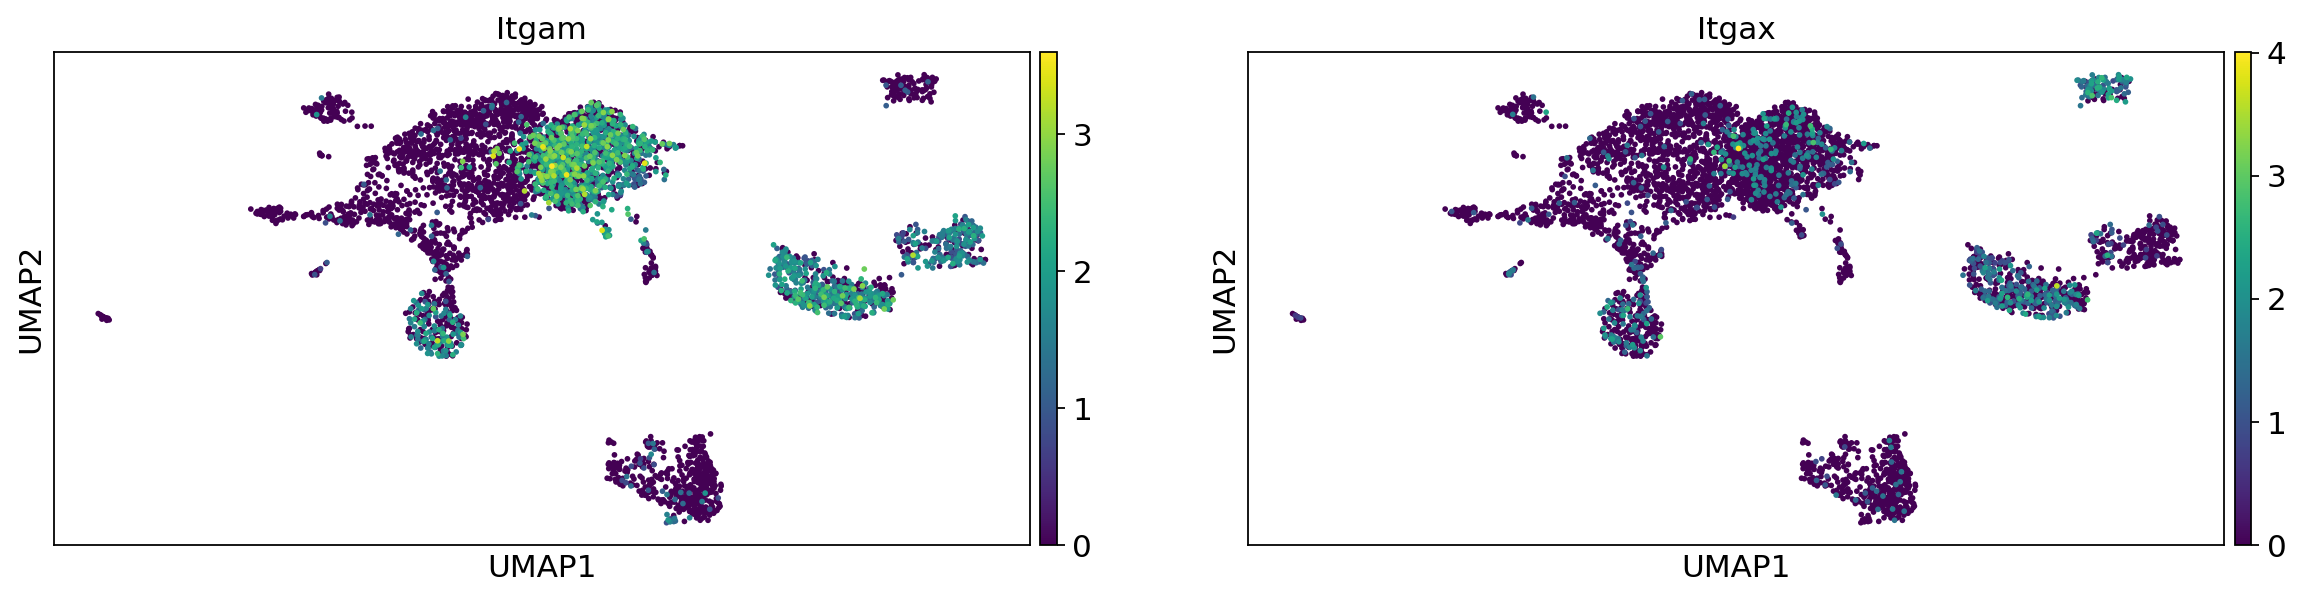

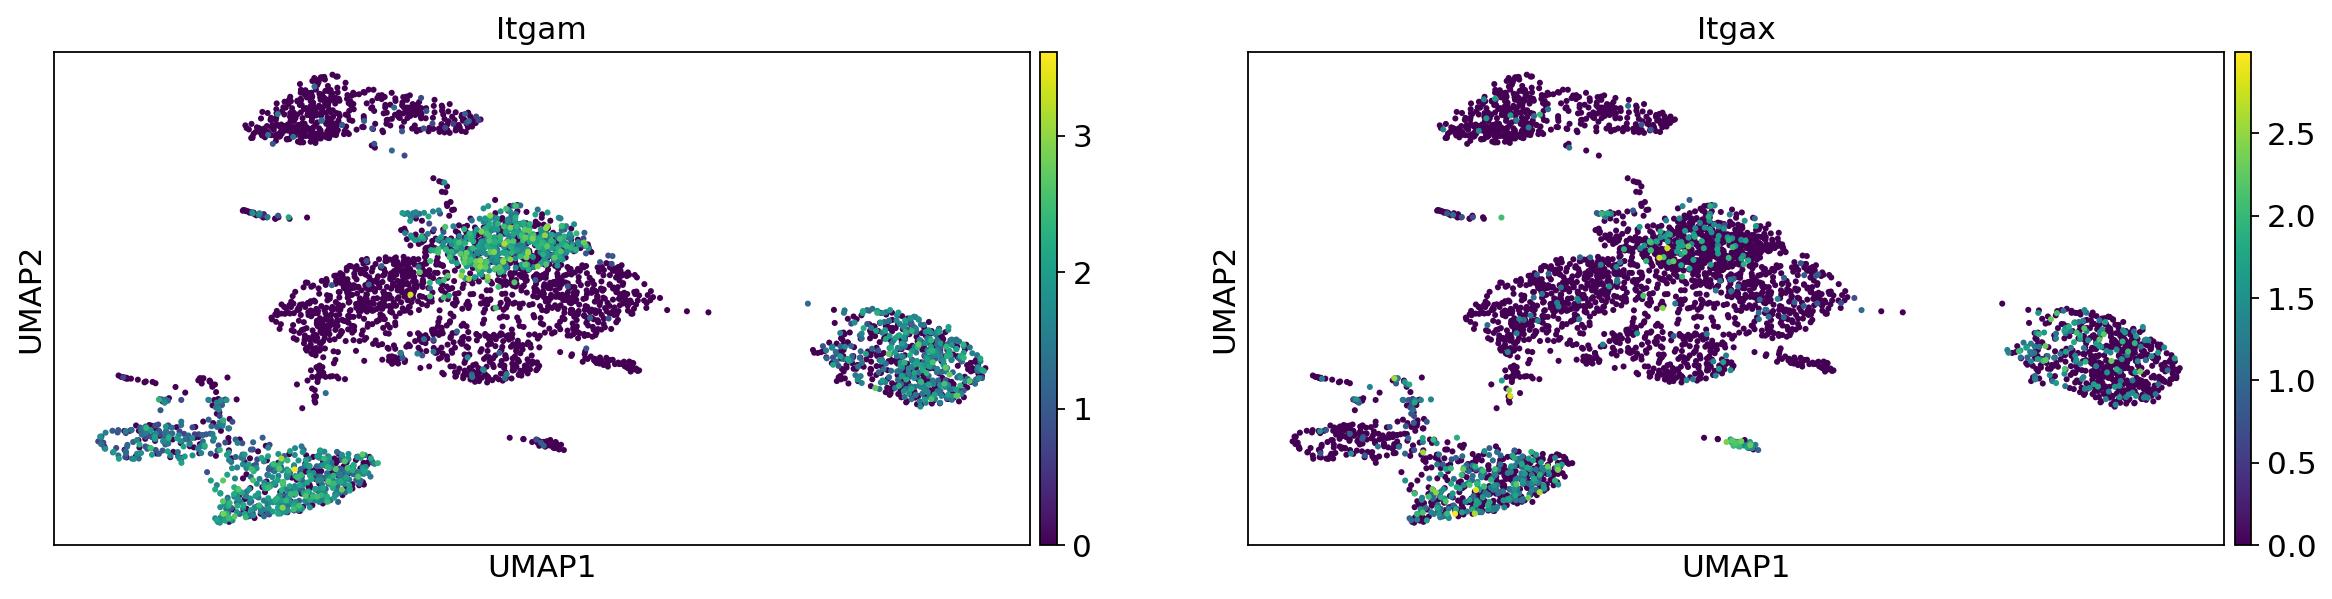

In [189]:
sc.pl.umap(adata_ki, color=['Itgam', 'Itgax'])
sc.pl.umap(adata_wt, color=['Itgam', 'Itgax'])

In [190]:
sc.tl.leiden(adata_ki)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [191]:
sc.tl.leiden(adata_wt)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


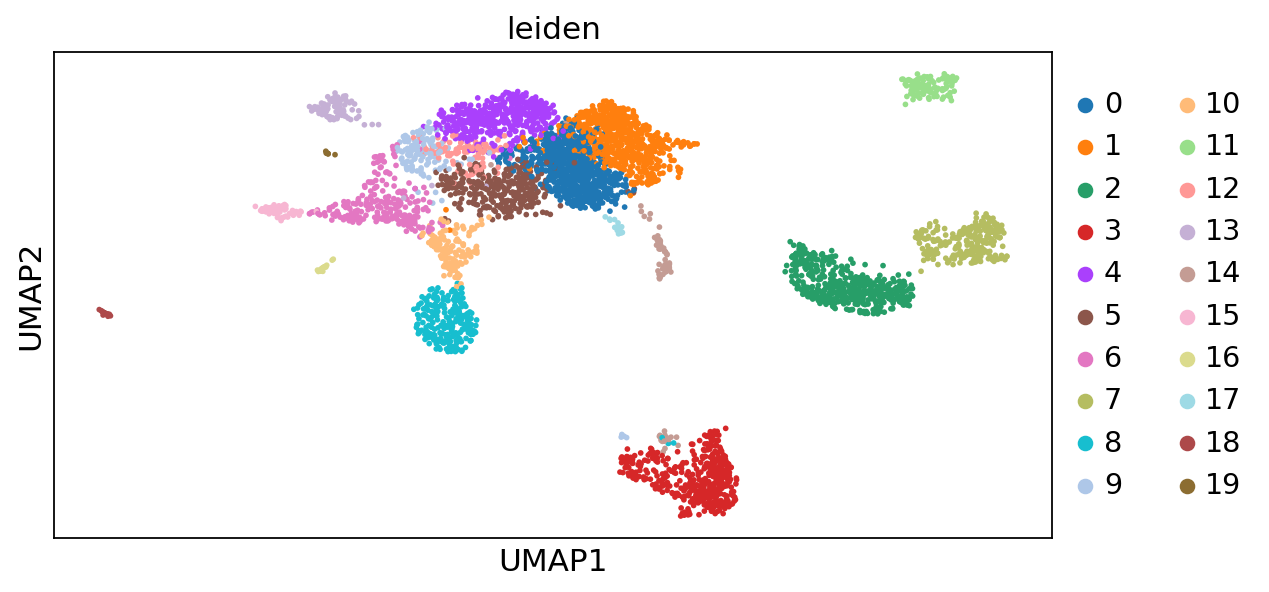

In [192]:
#sc.pl.umap(adata_ki, color=['leiden', 'Itgam', 'Itgax'])
sc.pl.umap(adata_ki, color='leiden')

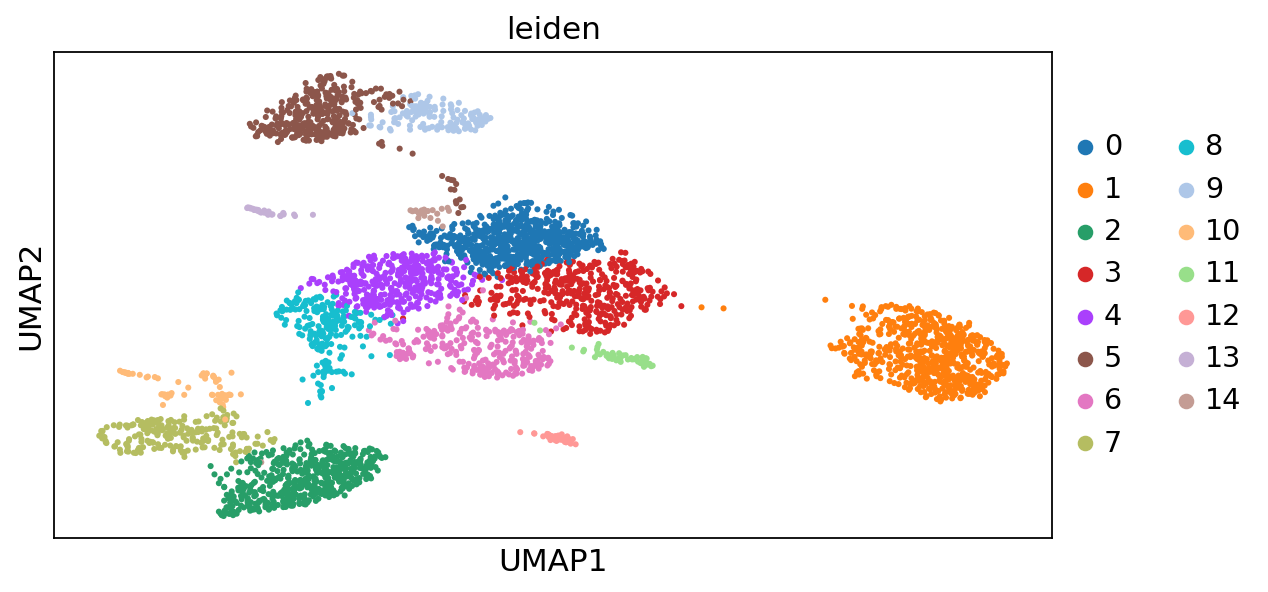

In [193]:
#sc.pl.umap(adata_wt, color=['leiden', 'Itgam', 'Itgax'])
sc.pl.umap(adata_wt, color='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


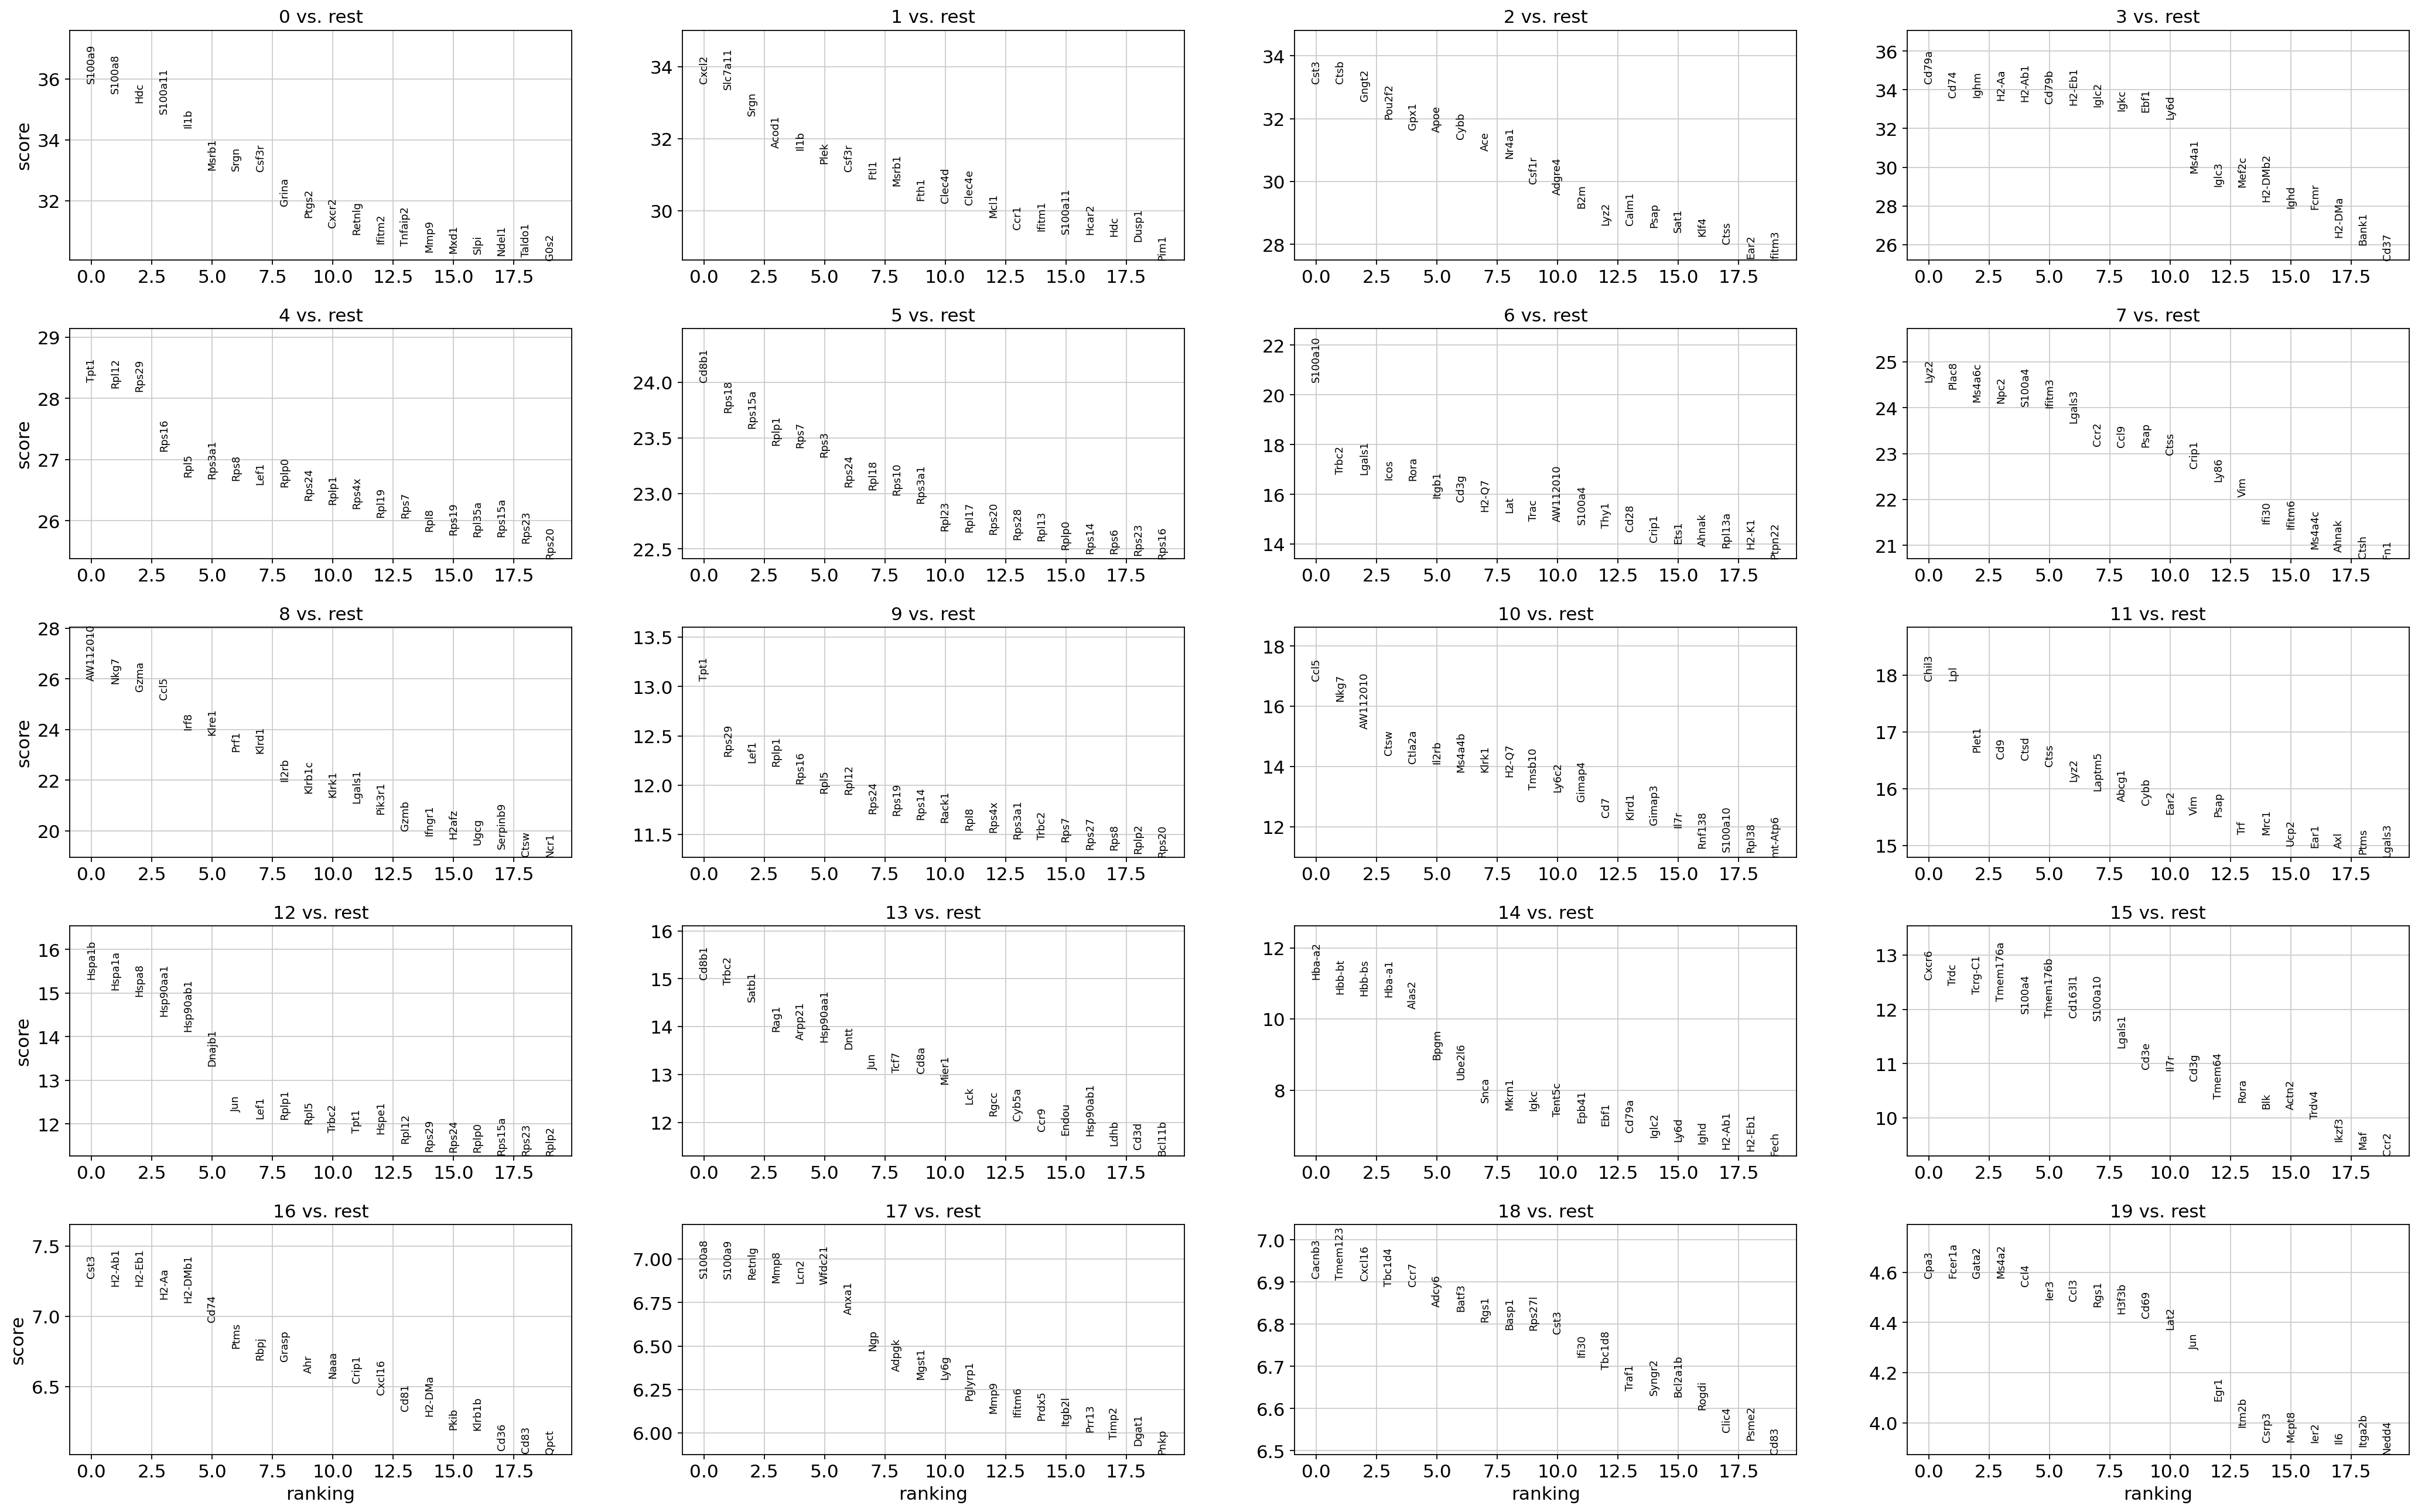

In [194]:
# Let us compute a ranking for the highly differential genes in each cluster (first group)
sc.tl.rank_genes_groups(adata_ki, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_ki, n_genes=20, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


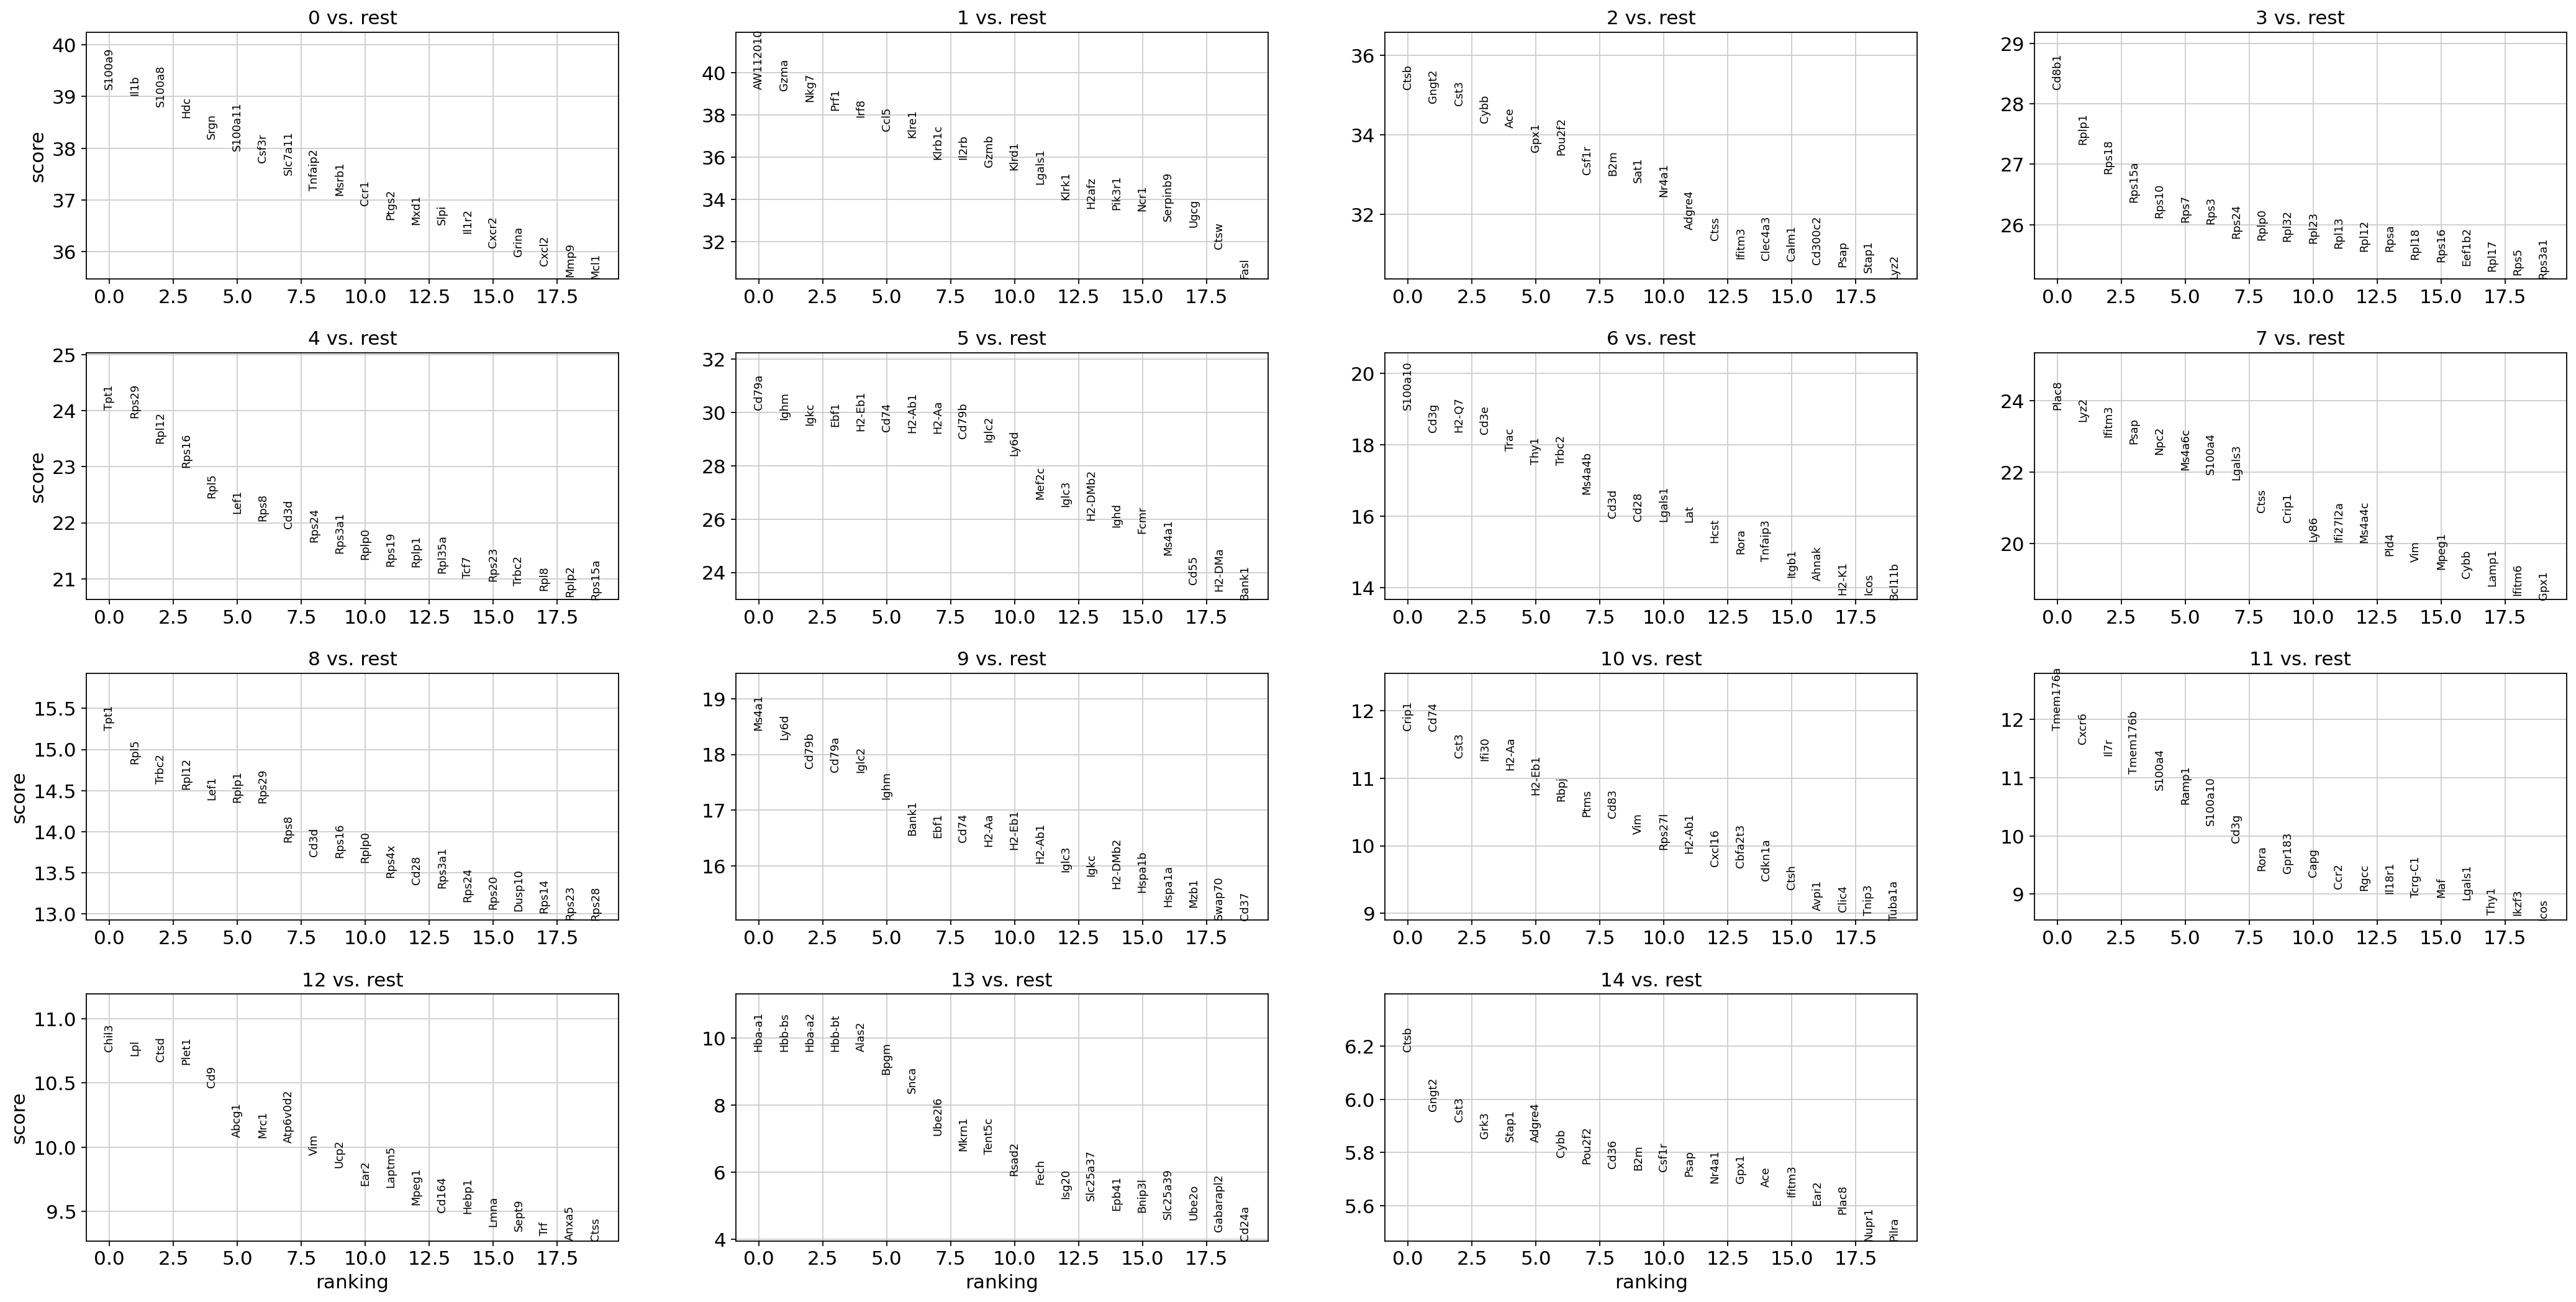

In [195]:
# Let us compute a ranking for the highly differential genes in each cluster (second group)
sc.tl.rank_genes_groups(adata_wt, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_wt, n_genes=20, sharey=False)

In [196]:
# Let's visualize some random selected genes by clusters
marker_genes = ['S100a9', 'Cxcl2', 'Cst3', 'Ccl5',  'Ctsb', 'S100a8', 'Nkg7', 'Klrb1', 'Cd79a', 'Chil3', 'Il1b']

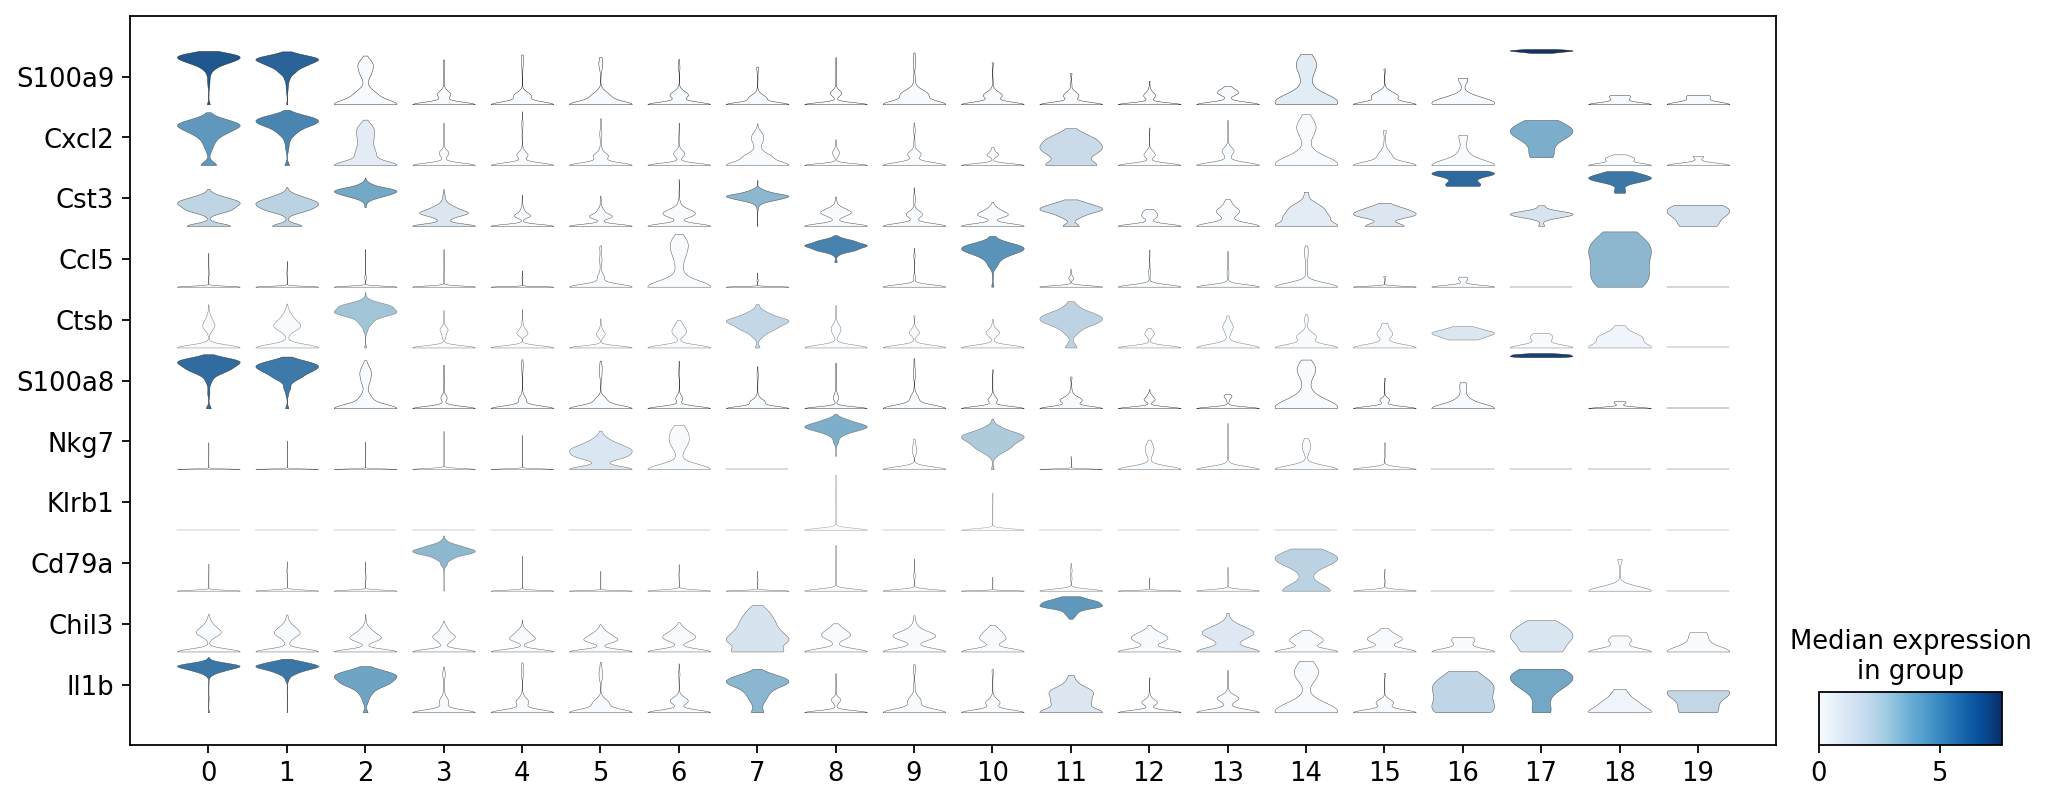

In [197]:
# Stacked violin plot for the first group by selected marker genes
sc.pl.stacked_violin(adata_ki, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,6))

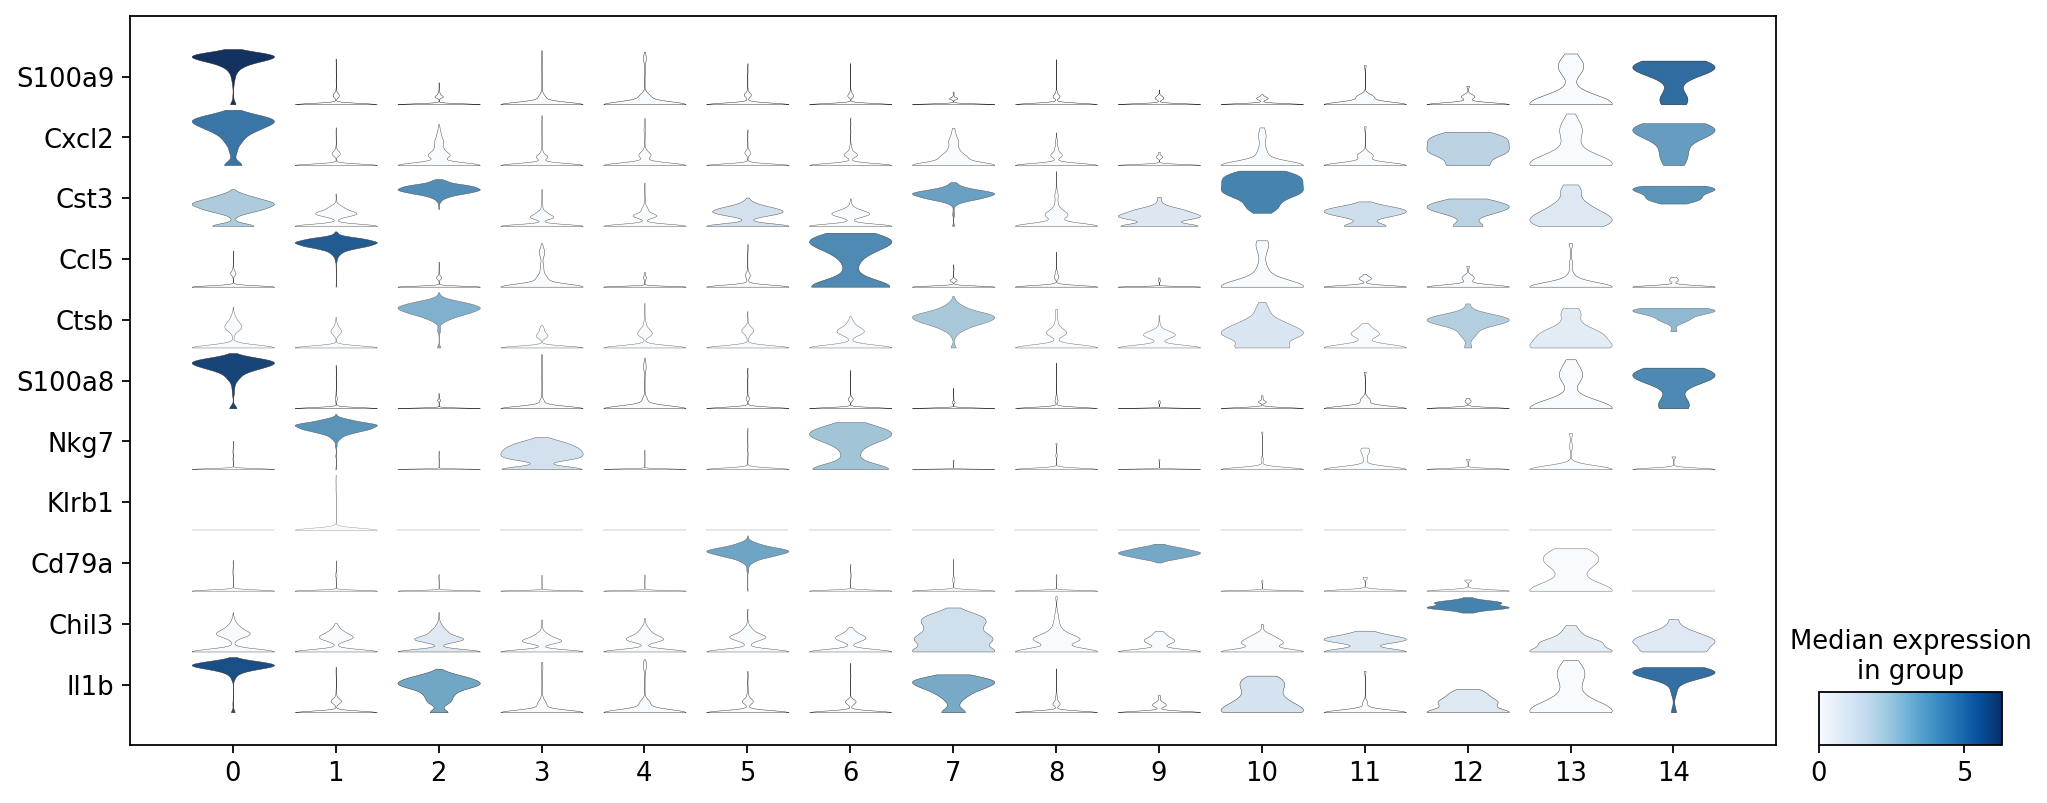

In [198]:
# Stacked violin plot for the second group by selected marker genes
sc.pl.stacked_violin(adata_wt, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,6))

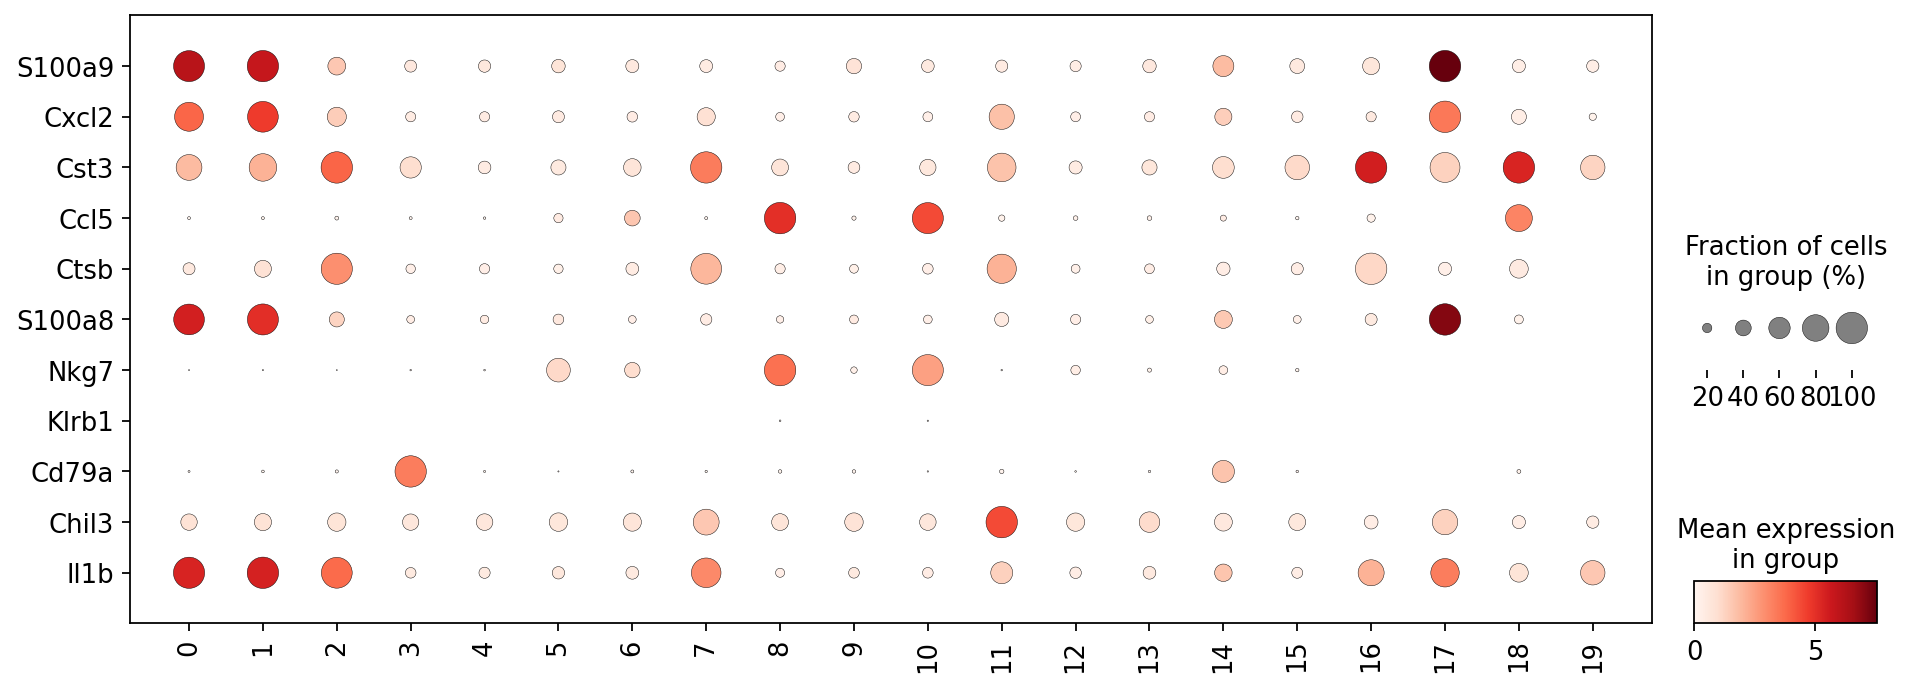

In [199]:
# The follwing plots are self-explanatory. The first one will be the first sample, and then the second sample
sc.pl.dotplot(adata_ki, marker_genes, groupby='leiden', swap_axes=True, figsize=(14,5))

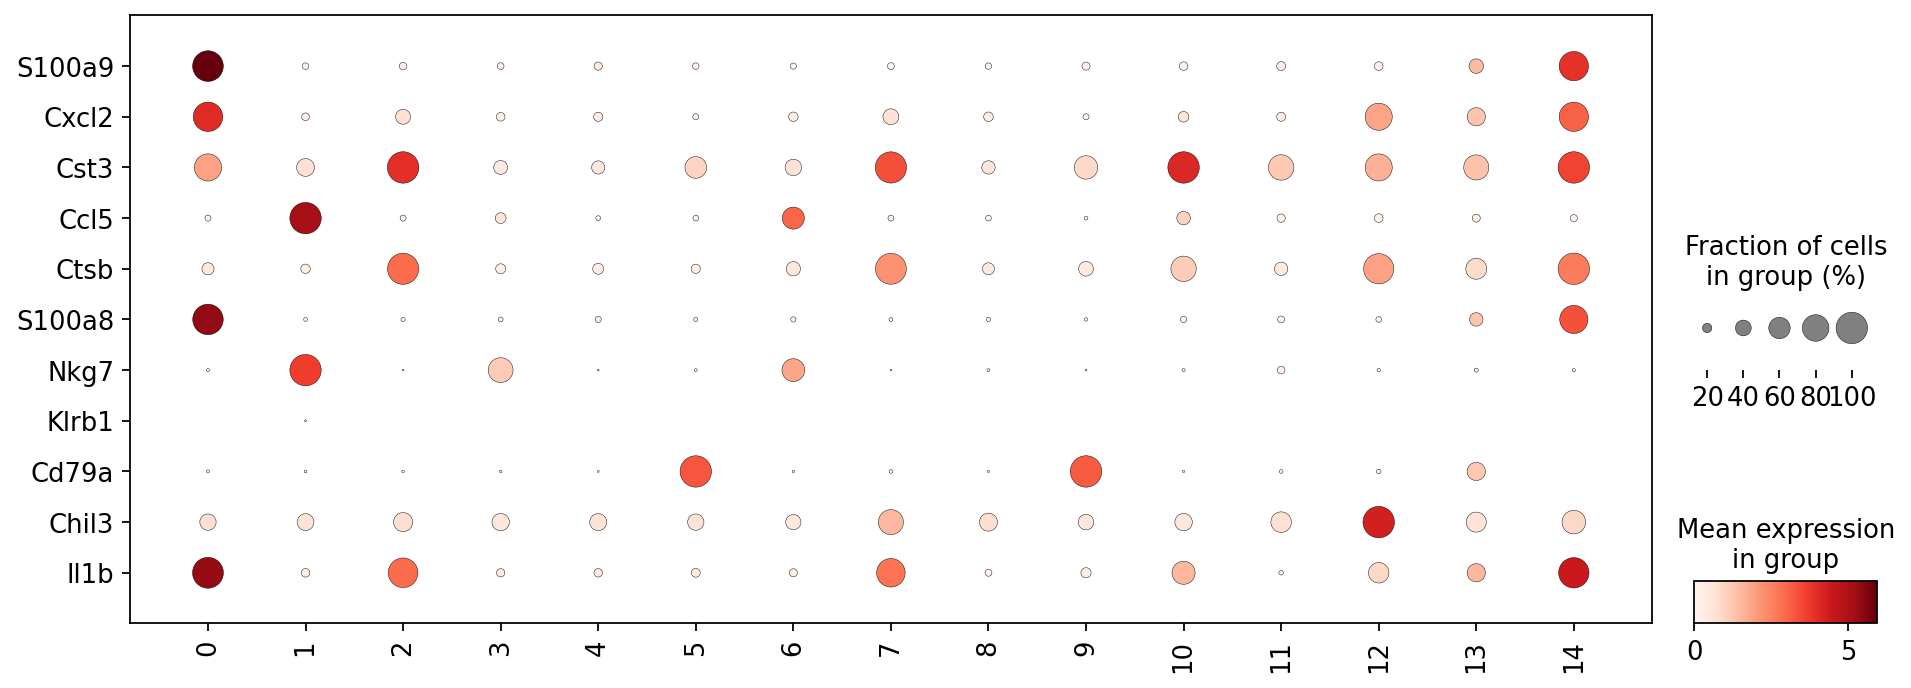

In [200]:
sc.pl.dotplot(adata_wt, marker_genes, groupby='leiden', swap_axes=True, figsize=(14,5))

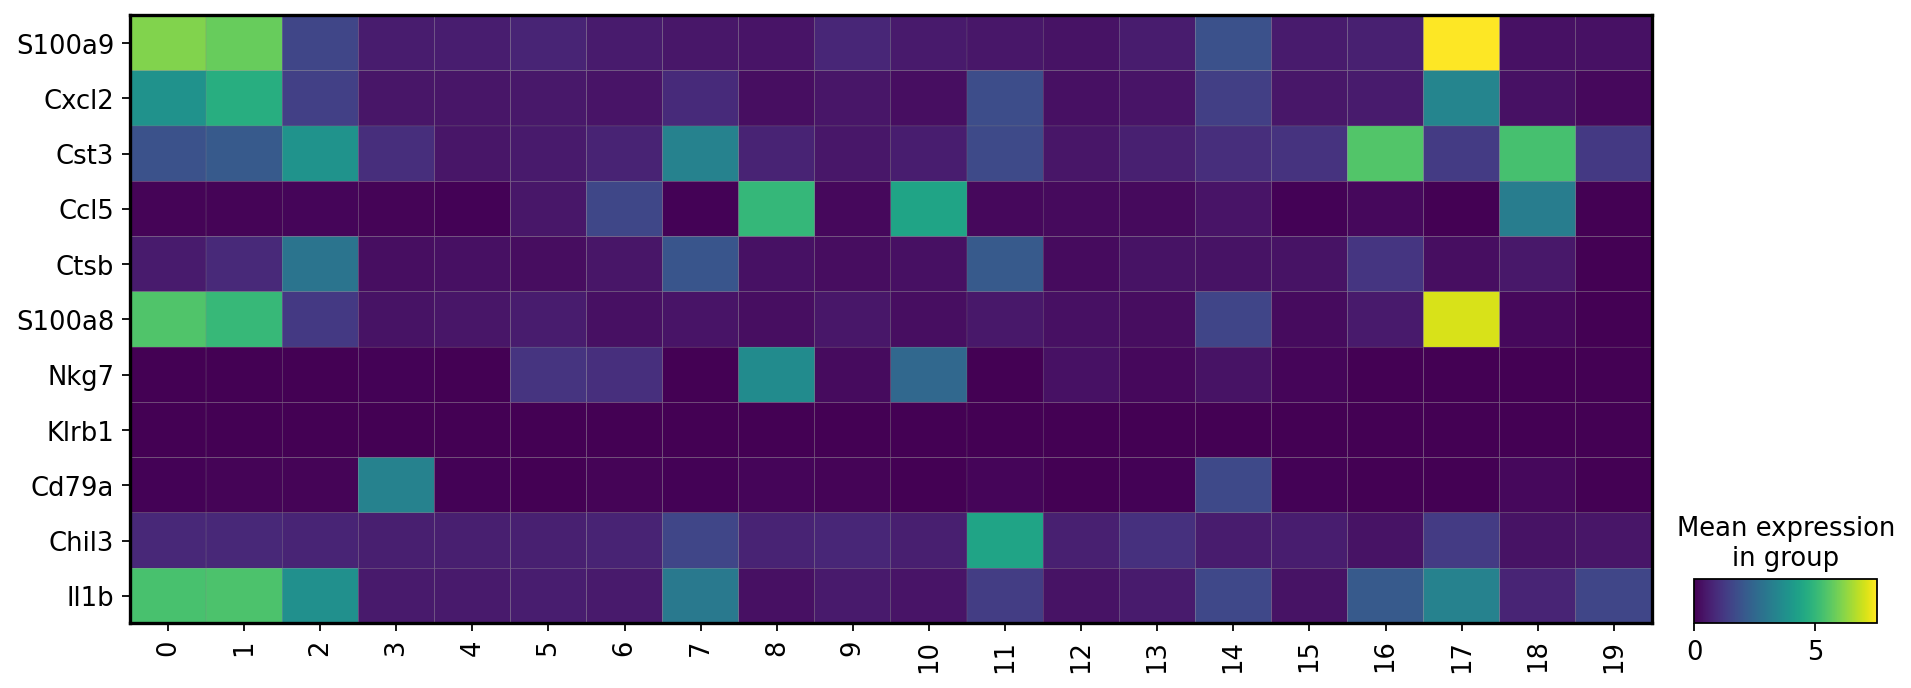

In [201]:
sc.pl.matrixplot(adata_ki, marker_genes, groupby='leiden', swap_axes=True, figsize=(14,5))

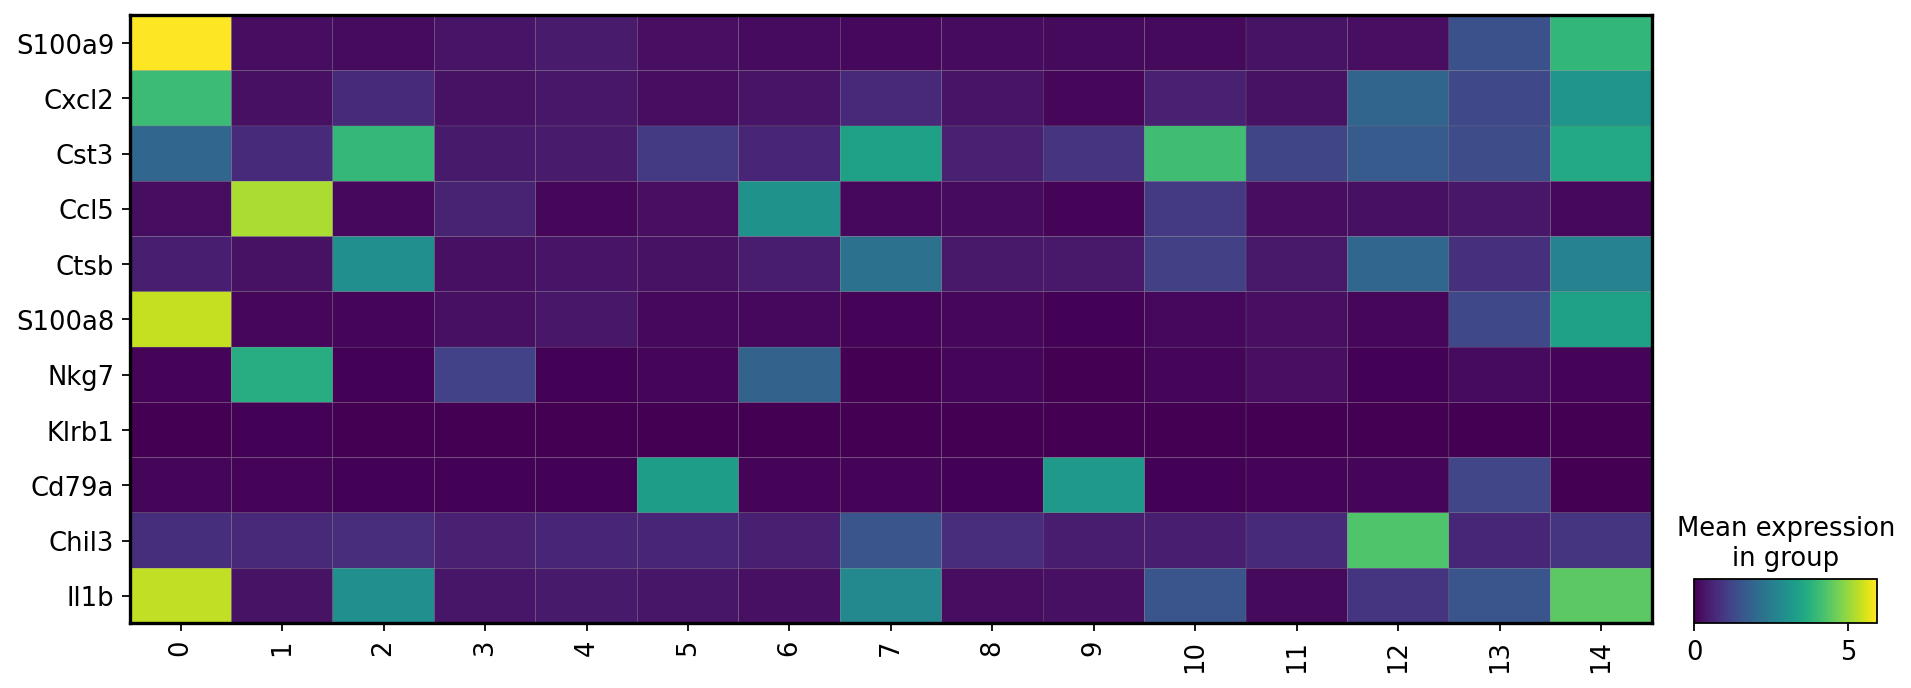

In [202]:
sc.pl.matrixplot(adata_wt, marker_genes, groupby='leiden', swap_axes=True, figsize=(14,5))

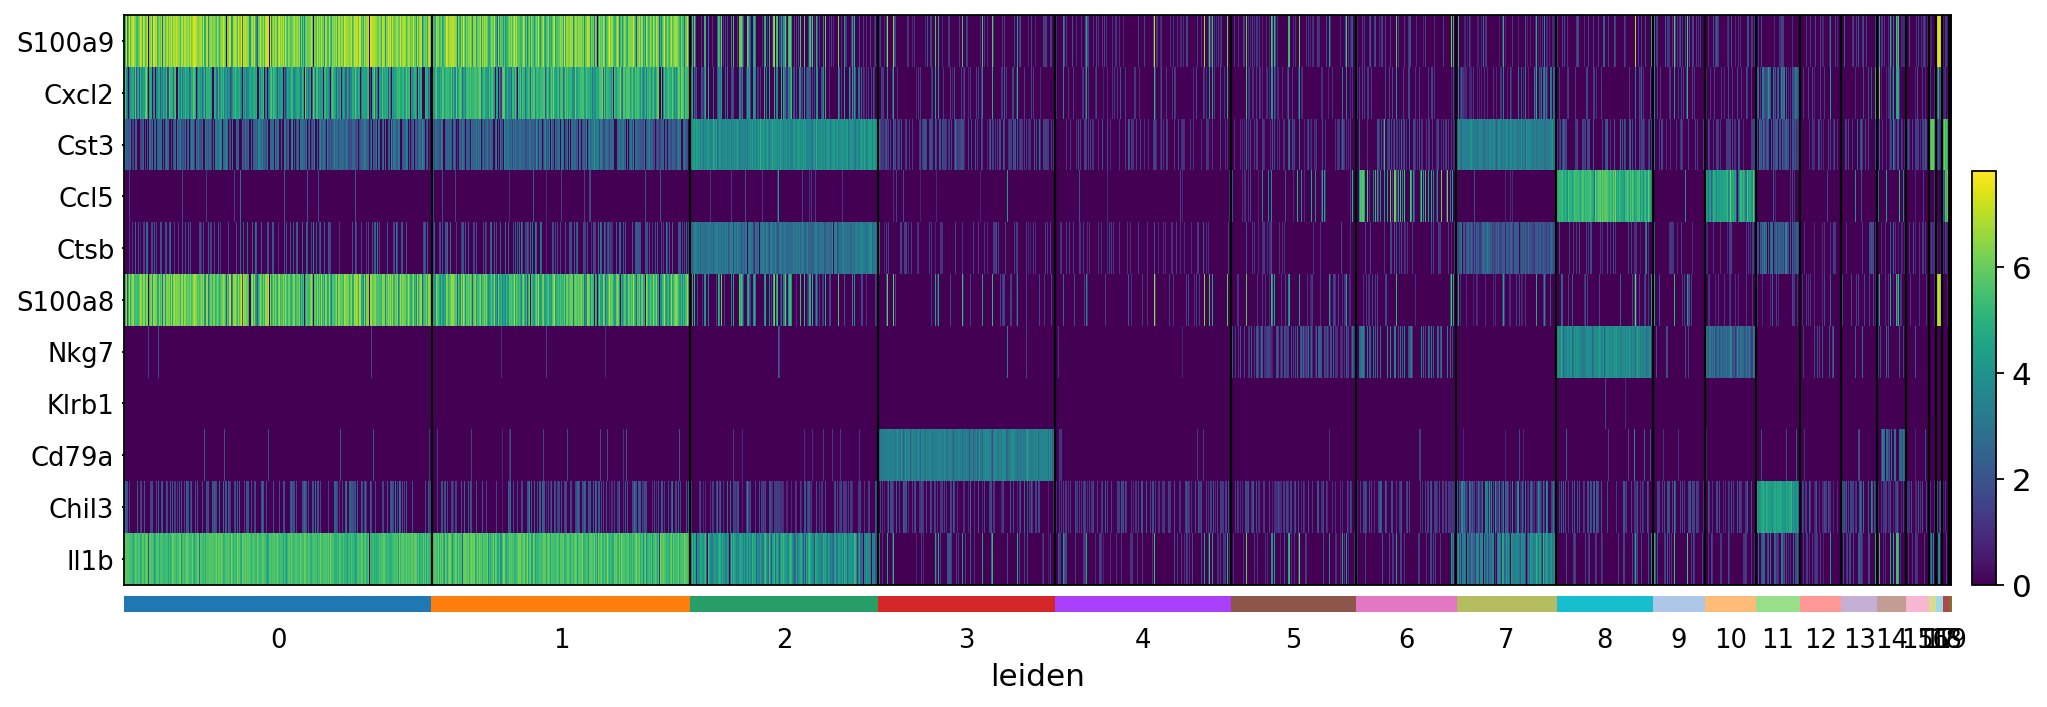

In [203]:
sc.pl.heatmap(adata_ki, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,5))

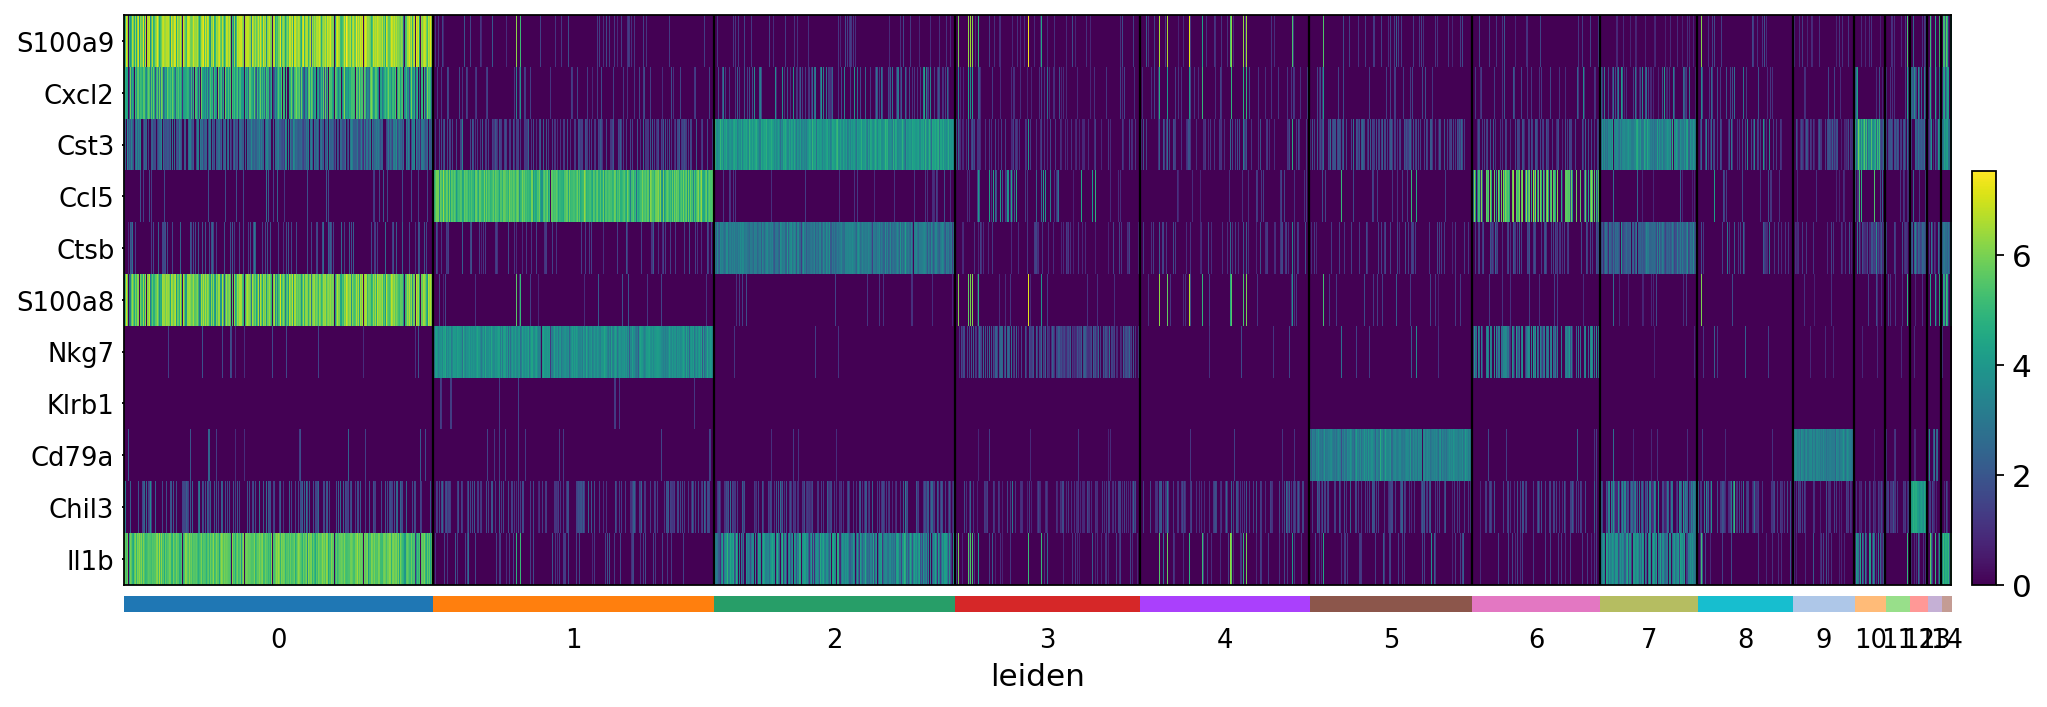

In [204]:
sc.pl.heatmap(adata_wt, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,5))

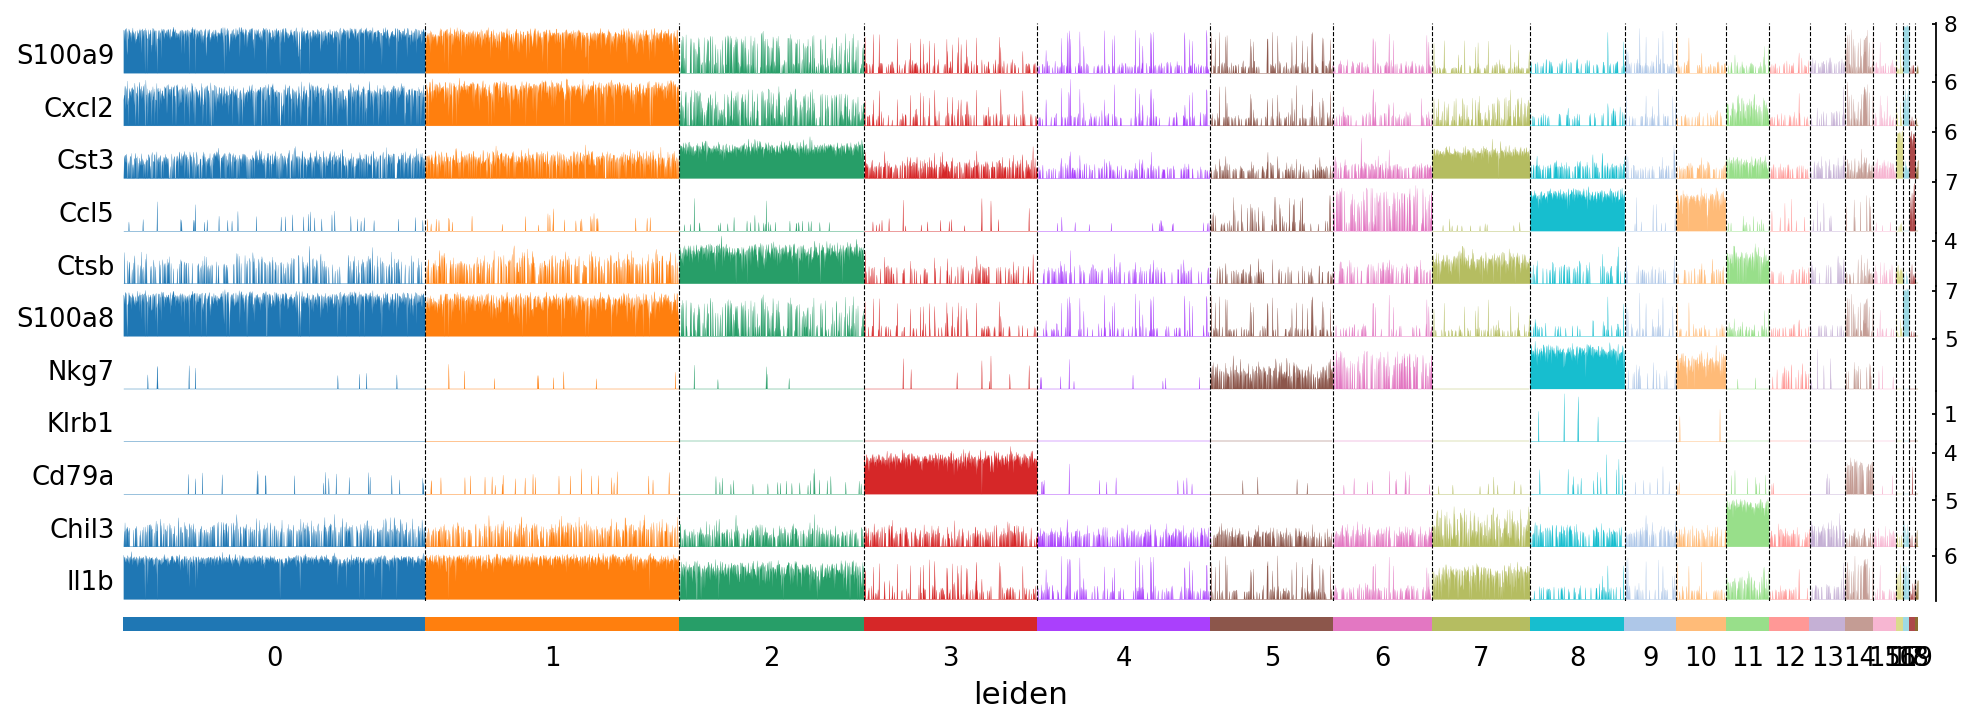

In [205]:
sc.pl.tracksplot(adata_ki, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,5))

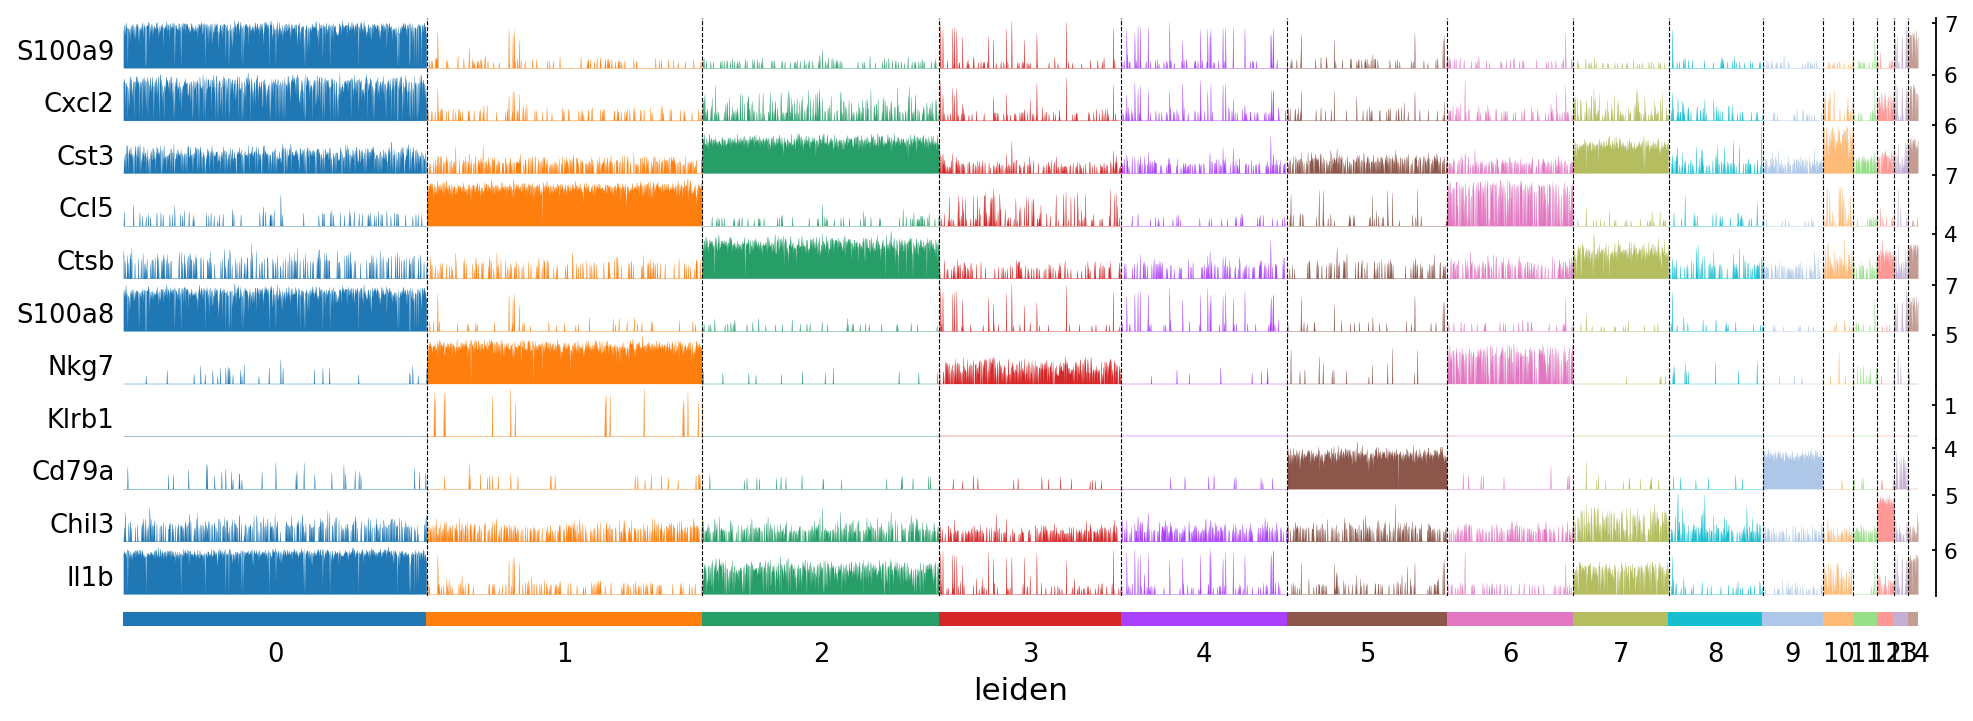

In [206]:
sc.pl.tracksplot(adata_wt, marker_genes, groupby='leiden', swap_axes=True, figsize=(15,5))